 # Importing the data

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import itertools
import warnings

In [2]:
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose as sd
from sklearn.metrics import mean_squared_error

In [3]:
pd.set_option('display.max_columns',None)
pd.set_option('display.max_rows',None)
pd.set_option('display.float_format', '{:4f}'.format)
warnings.filterwarnings('ignore')
warnings.simplefilter("ignore")

# Reading data and converting it into Time Series Format.

In [4]:
tmp = pd.read_csv('kc_house_data.csv')

In [5]:
tmp.head()

id             date         price  bedrooms  bathrooms  \
0  7129300520  20141013T000000 221900.000000         3   1.000000   
1  6414100192  20141209T000000 538000.000000         3   2.250000   
2  5631500400  20150225T000000 180000.000000         2   1.000000   
3  2487200875  20141209T000000 604000.000000         4   3.000000   
4  1954400510  20150218T000000 510000.000000         3   2.000000   

   sqft_living  sqft_lot   floors  waterfront  view  condition  grade  \
0         1180      5650 1.000000           0     0          3      7   
1         2570      7242 2.000000           0     0          3      7   
2          770     10000 1.000000           0     0          3      6   
3         1960      5000 1.000000           0     0          5      7   
4         1680      8080 1.000000           0     0          3      8   

   sqft_above  sqft_basement  yr_built  yr_renovated  zipcode       lat  \
0        1180              0      1955             0    98178 47.511200   
1        2170            400      1951          1991    98125 47.721000   
2         770              0      1933             0    98028 47.737900   
3        1050            910      1965             0    98136 47.520800   
4        1680              0      1987             0    98074 47.616800   

         long  sqft_living15  sqft_lot15  
0 -122.257000           1340        5650  
1 -122.319000           1690        7639  
2 -122.233000           2720        8062  
3 -122.393000           1360        5000  
4 -122.045000           1800        7503

In [6]:
tmp = tmp[['date','zipcode', 'price']].copy()
tmp['date'] = tmp['date'].str.replace("T000000","")
tmp['date']=pd.to_datetime(tmp['date'])
tmp.sort_values(by=['date','zipcode'],inplace=True)

In [7]:
tmp = tmp.groupby(['date','zipcode'],as_index=False)['price'].mean()

In [8]:
tmp.set_index('date',inplace=True)

# Resampling daily df to Monthly and replacing missing values.

In [9]:
tmp = tmp.groupby('zipcode',as_index=False).resample('MS').mean()

In [10]:
tmp = tmp.reset_index(level=0, drop=True)

In [11]:
tmp.isnull().sum()

zipcode    3
price      3
dtype: int64

In [12]:
tmp = tmp.fillna(method='ffill')

In [13]:
tmp['zipcode'] = tmp['zipcode'].astype(int)

In [14]:
tmp2 = tmp.copy()

# Plotting graph 

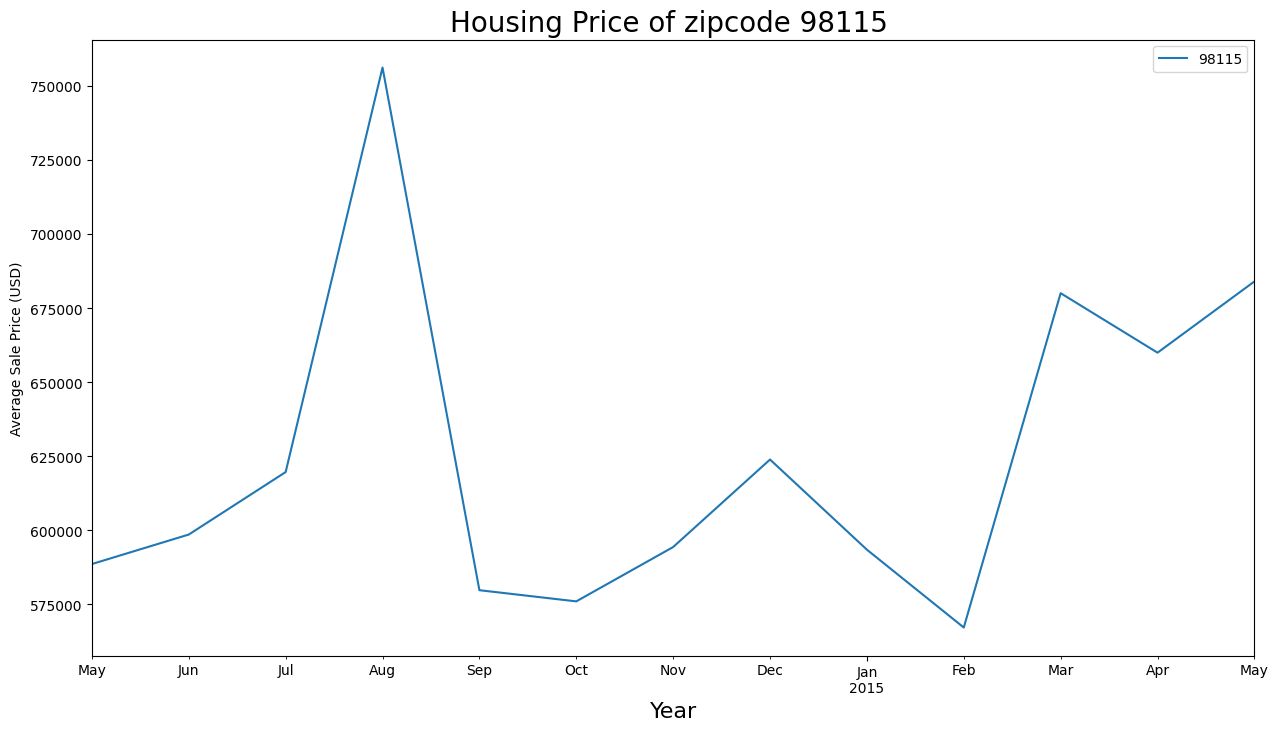

In [15]:
temp_df = tmp[tmp.zipcode == 98115]
temp_df['price'].plot(figsize = (15,8), label=98115)

plt.legend()
plt.xlabel("Year", fontsize = 16)
plt.ylabel("Average Sale Price (USD)")
plt.title('Housing Price of zipcode 98115 ', fontsize = 20);

{'whiskers': [<matplotlib.lines.Line2D at 0x228415d4b00>,
 'caps': [<matplotlib.lines.Line2D at 0x228415c5a90>,
 'boxes': [<matplotlib.lines.Line2D at 0x228415d4828>],
 'medians': [<matplotlib.lines.Line2D at 0x228415e76d8>],
 'fliers': [<matplotlib.lines.Line2D at 0x228415e79b0>],
 'means': []}

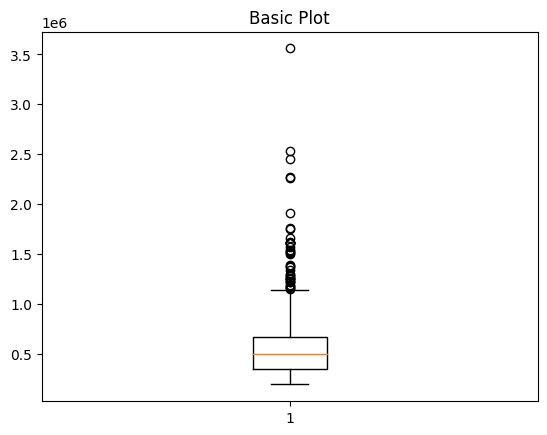

In [16]:
fig1, ax1 = plt.subplots()
ax1.set_title('Basic Plot')
ax1.boxplot(tmp['2014':]['price'])

# Calculating monthly average of the whole dataset

In [17]:
mon_avg = tmp.groupby('date')['price'].mean()
mon_avg = mon_avg.to_frame()
mon_avg

price
date                    
2014-05-01 556545.228831
2014-06-01 560571.803204
2014-07-01 564627.742639
2014-08-01 543928.054378
2014-09-01 557008.961657
2014-10-01 567173.487753
2014-11-01 536858.983474
2014-12-01 552552.262845
2015-01-01 557205.952435
2015-02-01 535948.589125
2015-03-01 553395.927668
2015-04-01 583110.821671
2015-05-01 586219.128143

Text(0.5, 1.0, 'House prices by monthly average')

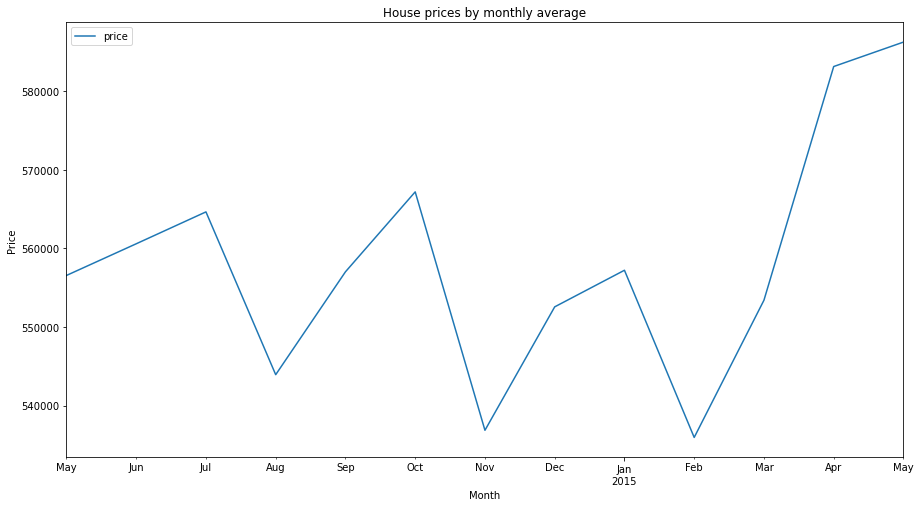

In [18]:
mon_avg.plot(figsize = (15,8), label="Monthly Average")
plt.xlabel('Month')
plt.ylabel('Price')
plt.title('House prices by monthly average')

# Sesonal Decomposition

### Using period value of 3 because of less quantity of data

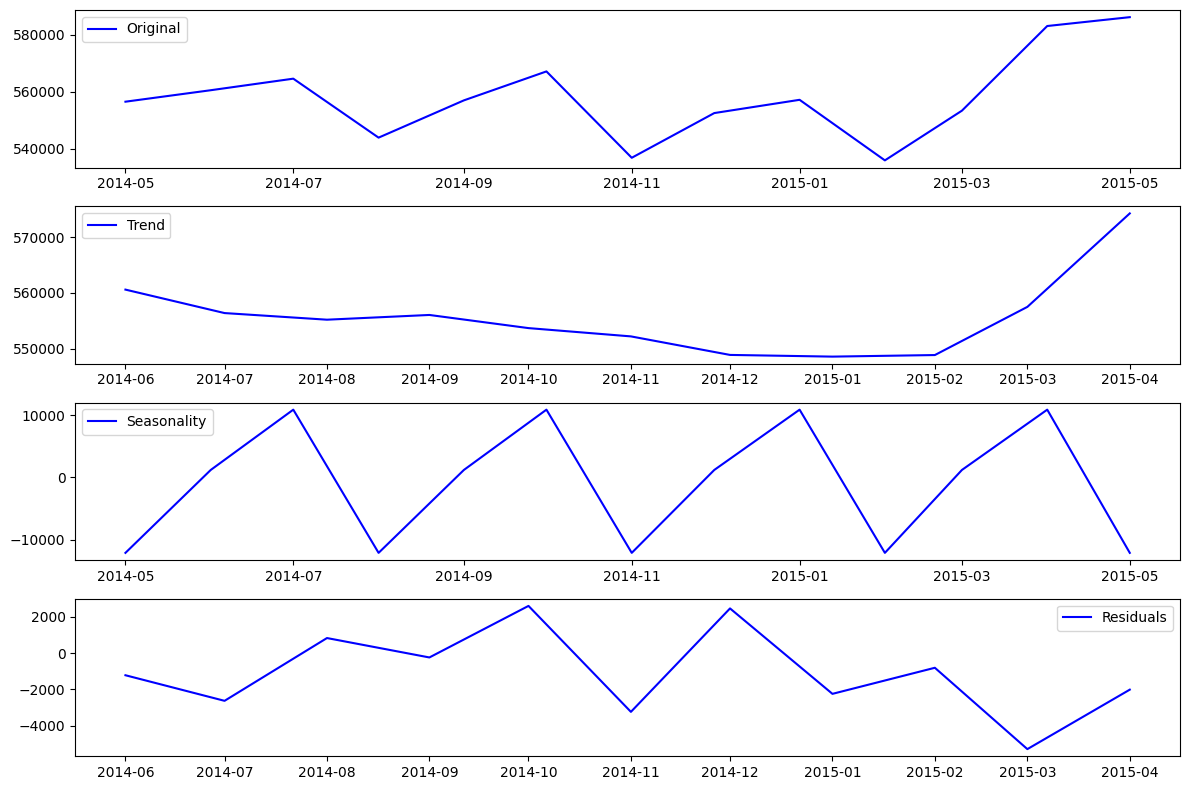

In [18]:
decomposition = sm.tsa.seasonal_decompose(mon_avg, period=3 , model='additive')

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.figure(figsize=(12,8))
plt.subplot(411)
plt.plot(mon_avg, label='Original', color='blue')
plt.legend(loc='best')

plt.subplot(412)
plt.plot(trend, label='Trend', color='blue')
plt.legend(loc='best')

plt.subplot(413)
plt.plot(seasonal,label='Seasonality', color='blue')
plt.legend(loc='best')

plt.subplot(414)
plt.plot(residual, label='Residuals', color='blue')
plt.legend(loc='best')

plt.tight_layout()

# Checking stationarity

In [19]:
def stationarity_check(TS):
    from statsmodels.tsa.stattools import adfuller
    
    roll_mean = TS.rolling(window=2, center=False).mean()
    roll_std = TS.rolling(window=2, center=False).std()
    
    dftest = adfuller(TS) 
    
    fig = plt.figure(figsize=(12,6))
    orig = plt.plot(TS, color='blue',label='Original')
    mean = plt.plot(roll_mean, color='red', label='Rolling Mean')
    #std = plt.plot(roll_std, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    print('Results of Dickey-Fuller Test: \n')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', 
                                             '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    return None

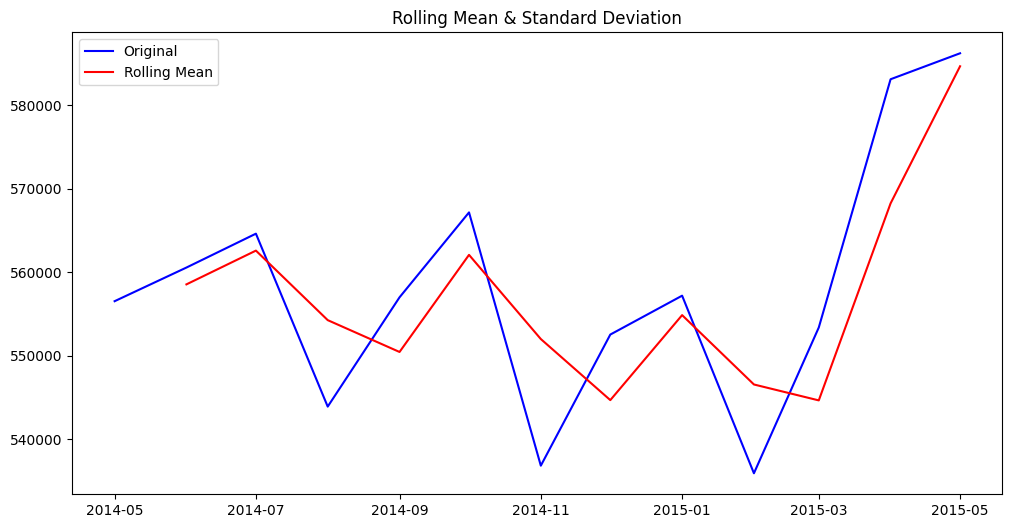

Results of Dickey-Fuller Test: 

Test Statistic                -0.530961
p-value                        0.885832
#Lags Used                     3.000000
Number of Observations Used    9.000000
Critical Value (1%)           -4.473135
Critical Value (5%)           -3.289881
Critical Value (10%)          -2.772382
dtype: float64


In [20]:
stationarity_check(mon_avg)

## The monthly average data we have calculated is not stationary.

# Making the monthly average data stationary

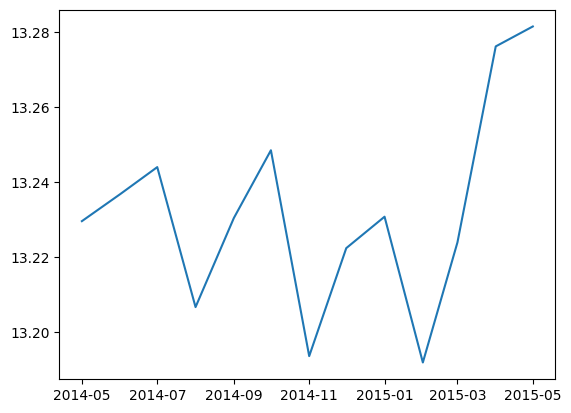

In [21]:
plt.plot(np.log(mon_avg))

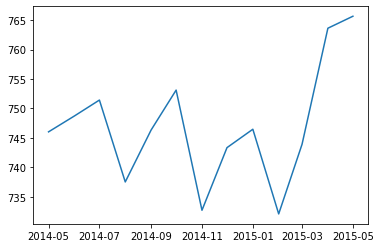

In [23]:
plt.plot(np.sqrt(mon_avg))

## Calculalting Differencing

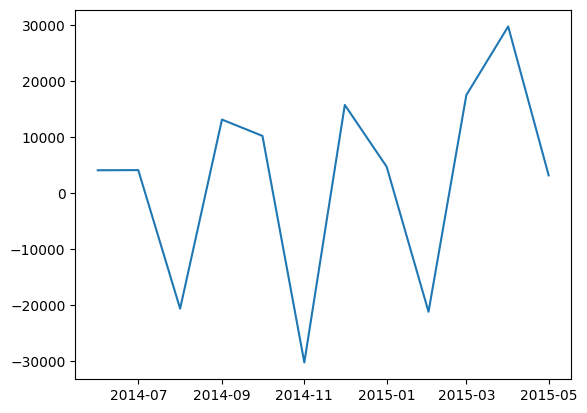

In [22]:
plt.plot(mon_avg['price'].diff(periods = 1))

In [23]:
mon_avg

price
date                    
2014-05-01 556545.228831
2014-06-01 560571.803204
2014-07-01 564627.742639
2014-08-01 543928.054378
2014-09-01 557008.961657
2014-10-01 567173.487753
2014-11-01 536858.983474
2014-12-01 552552.262845
2015-01-01 557205.952435
2015-02-01 535948.589125
2015-03-01 553395.927668
2015-04-01 583110.821671
2015-05-01 586219.128143

### Autocorrelation

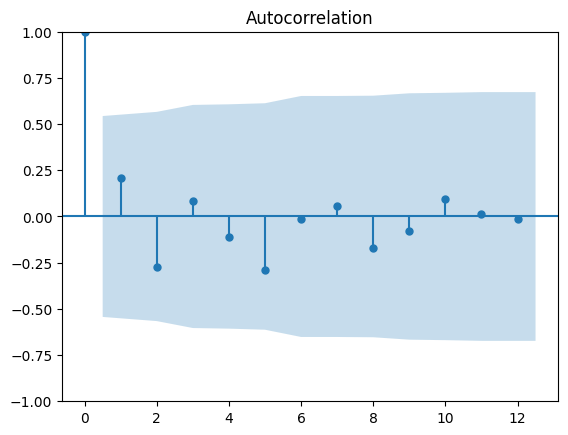

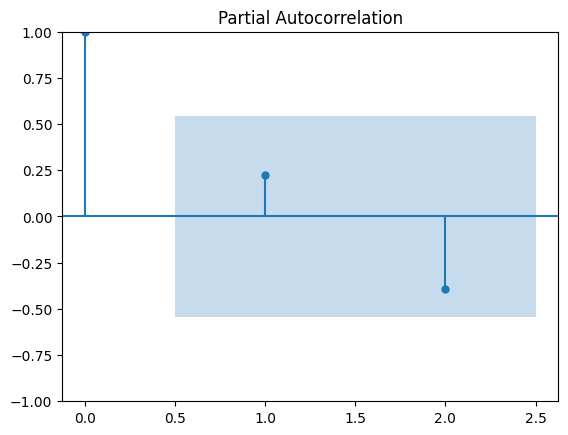

In [24]:
plot_acf(mon_avg); plt.show()
plot_pacf(mon_avg,lags=2);
plt.show()

# Checking stationarity on subset of dataset i.e. zipcode 98001

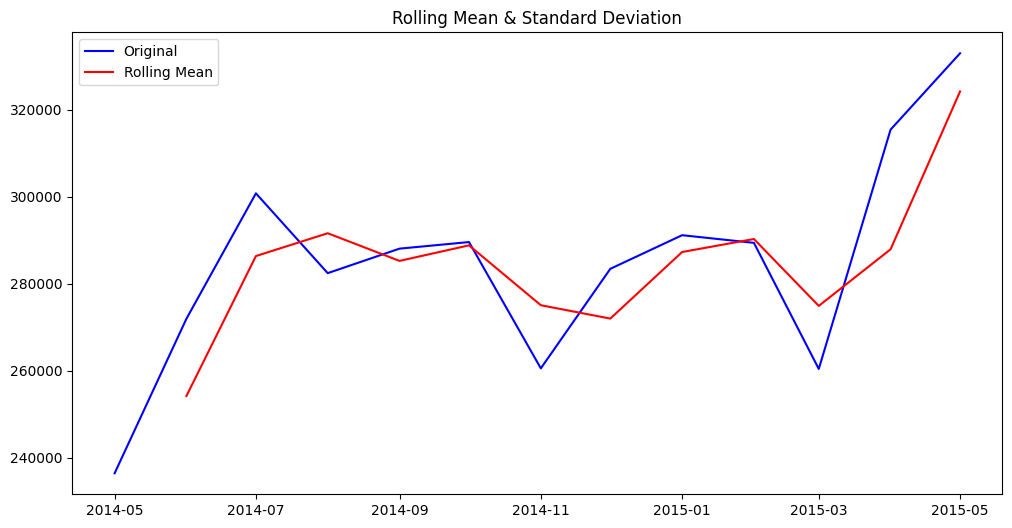

Results of Dickey-Fuller Test: 

Test Statistic                -2.417984
p-value                        0.136725
#Lags Used                     1.000000
Number of Observations Used   11.000000
Critical Value (1%)           -4.223238
Critical Value (5%)           -3.189369
Critical Value (10%)          -2.729839
dtype: float64


In [25]:
stationarity_check(tmp[tmp['zipcode']==98001].drop('zipcode',axis=1).dropna())

# Plotting graph for every zipcode

In [26]:
zip_dfs = []
lst = tmp['zipcode'].unique() 
for x in lst:
    zip_dfs.append(pd.DataFrame(tmp[tmp['zipcode']==x][['price']].copy()))

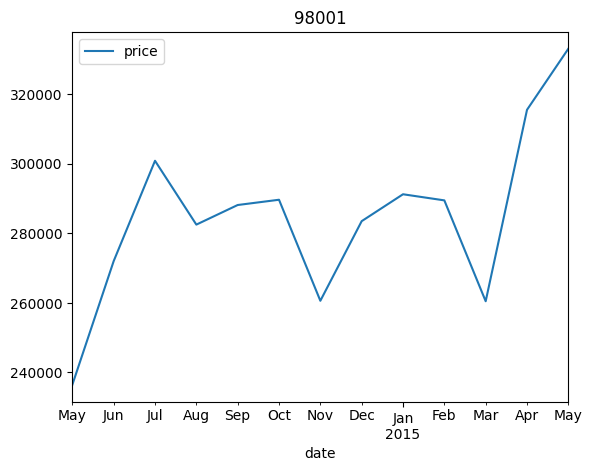

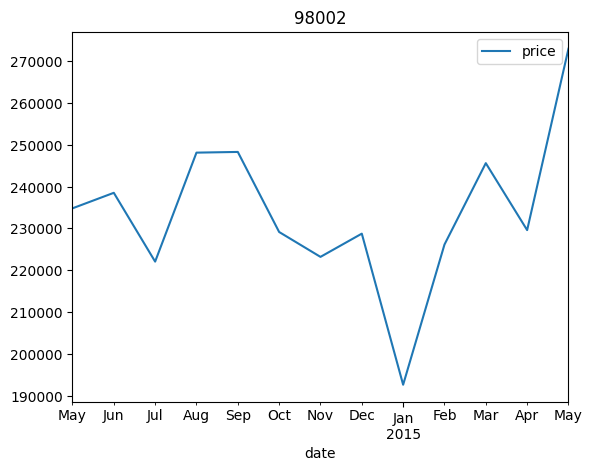

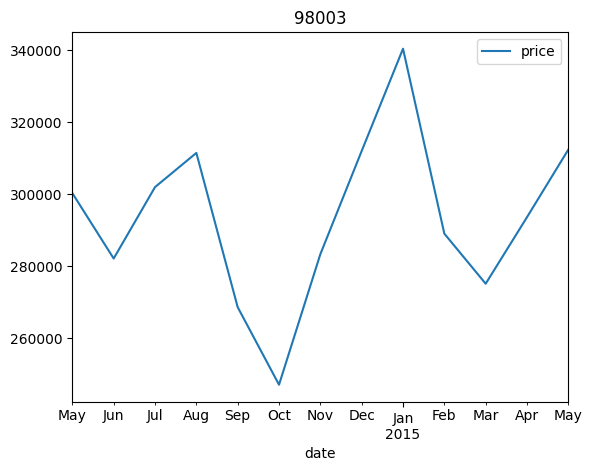

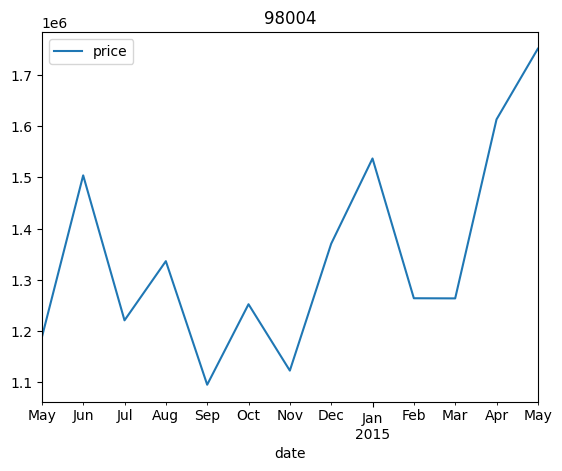

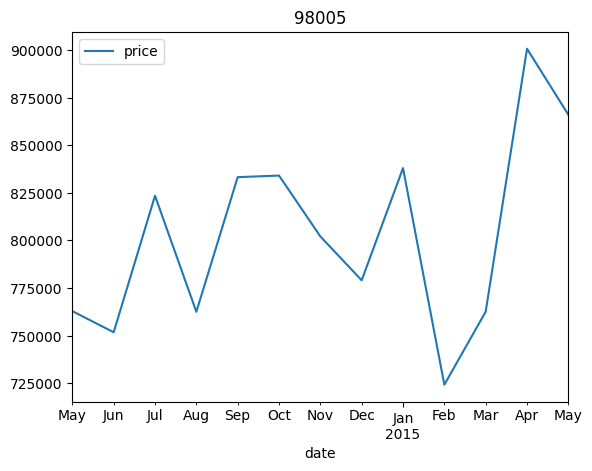

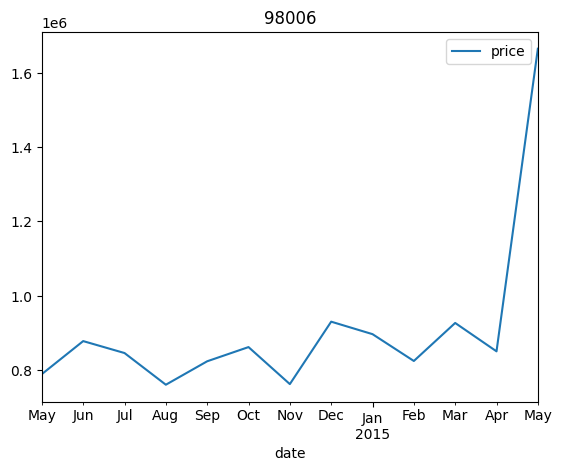

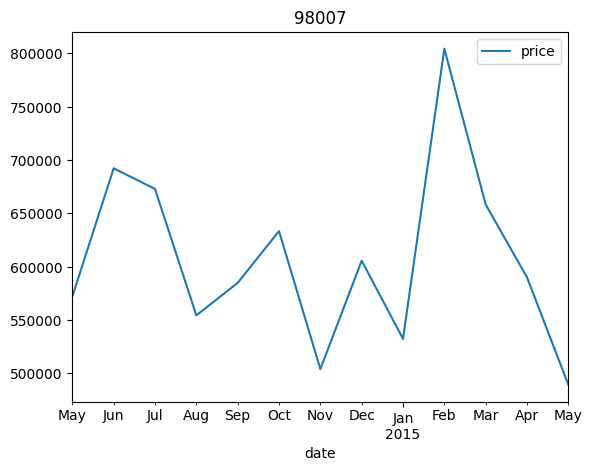

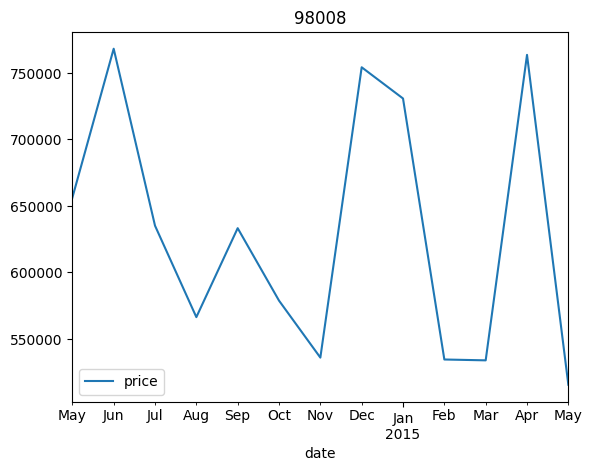

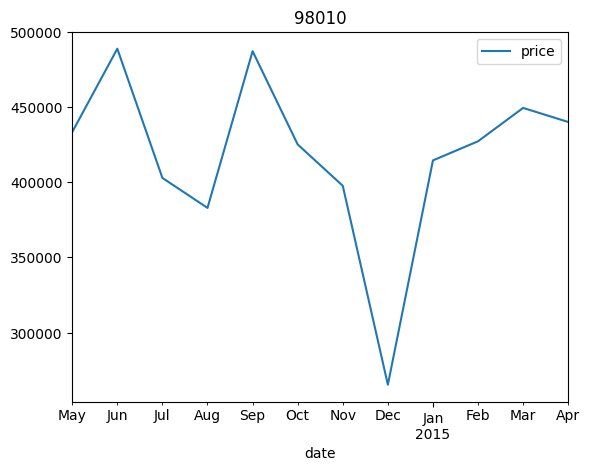

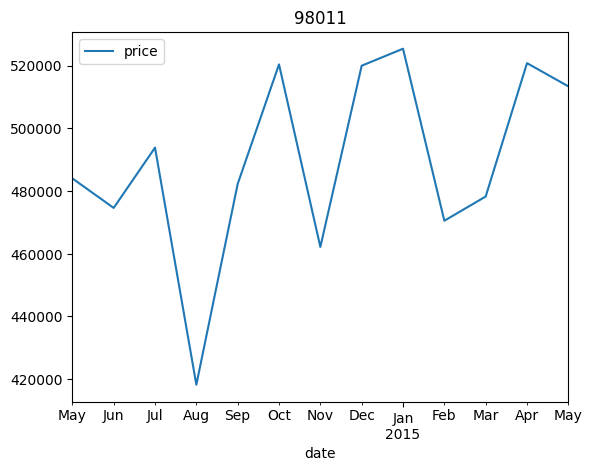

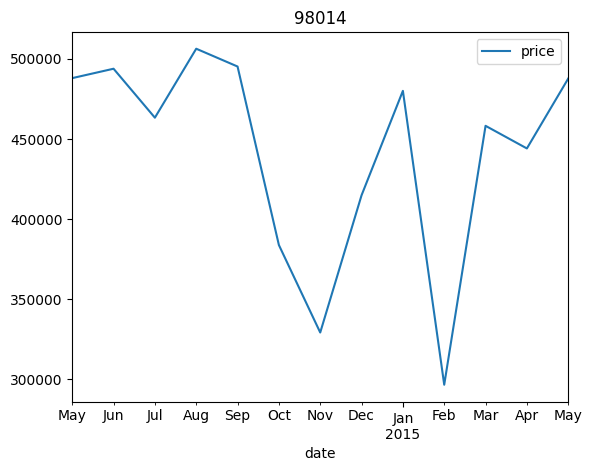

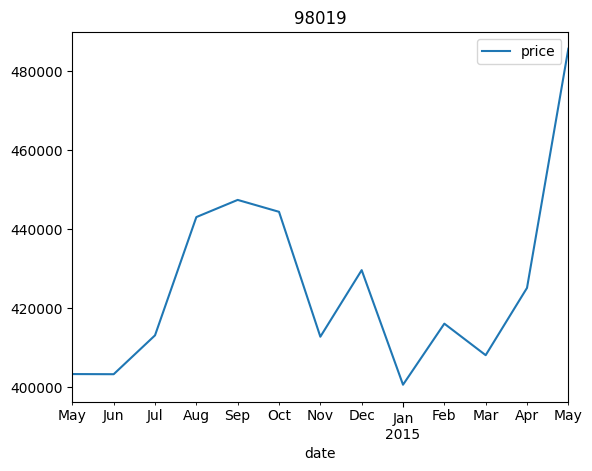

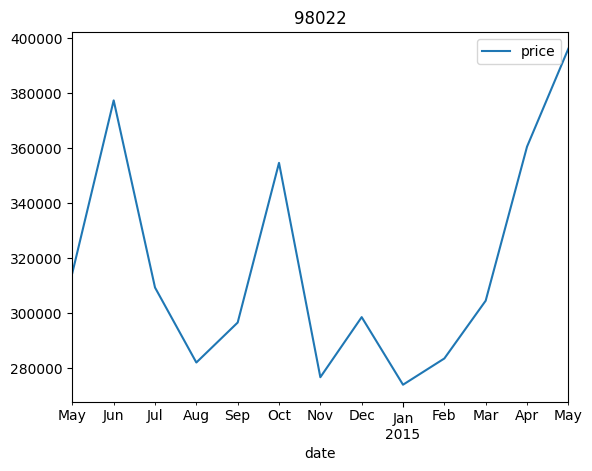

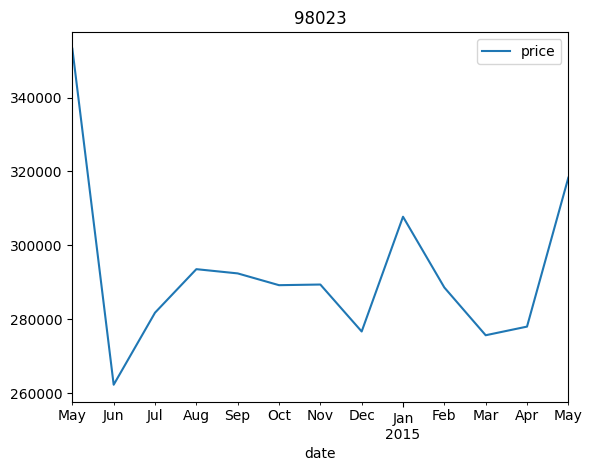

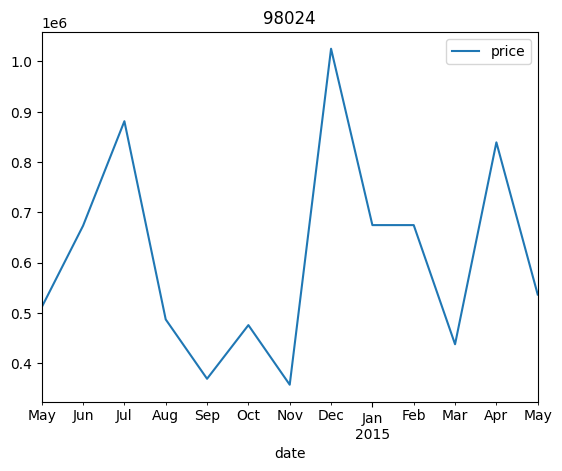

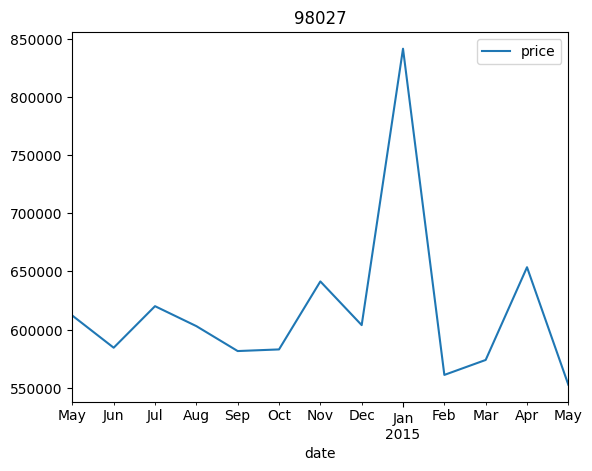

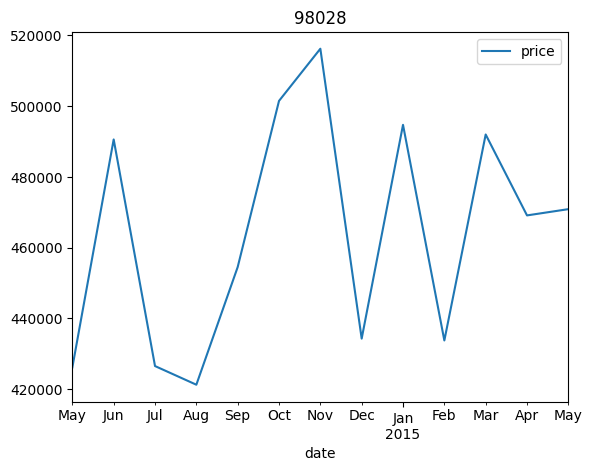

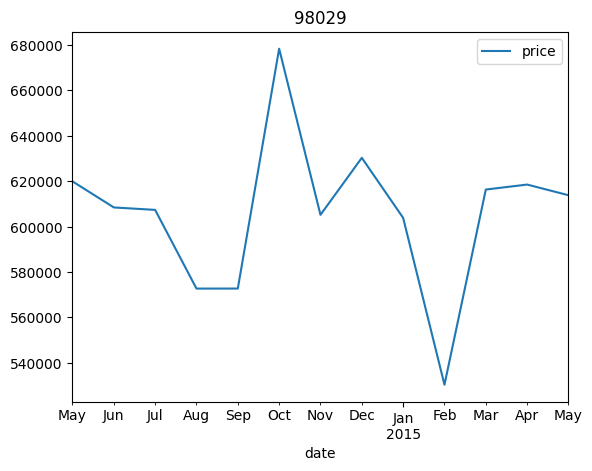

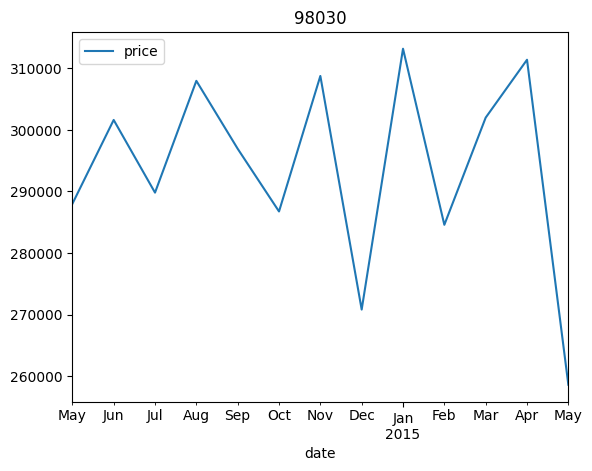

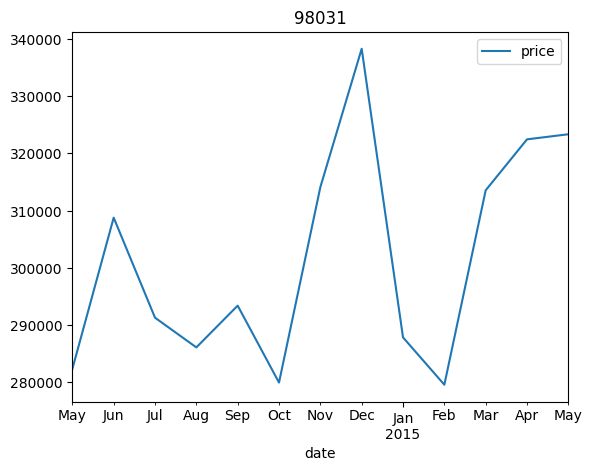

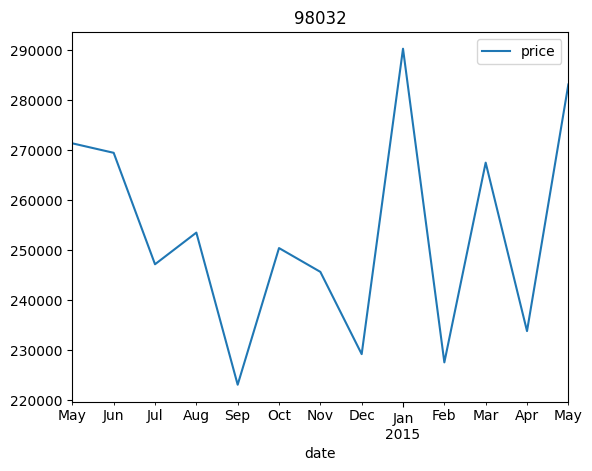

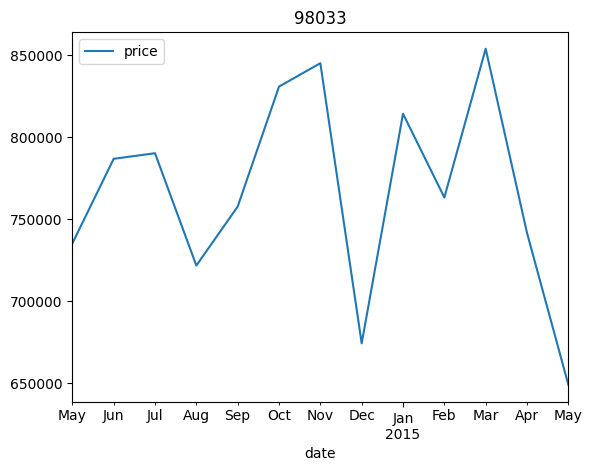

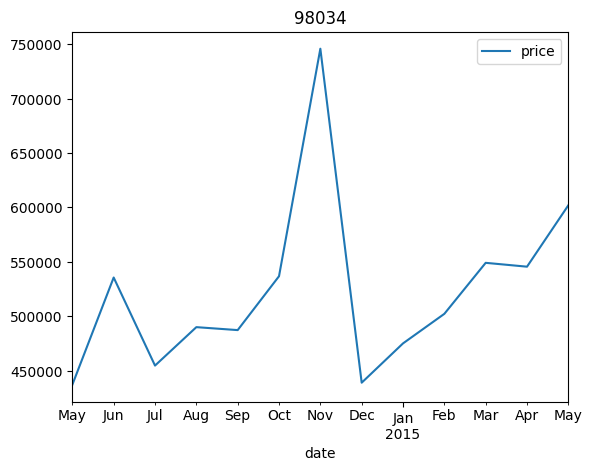

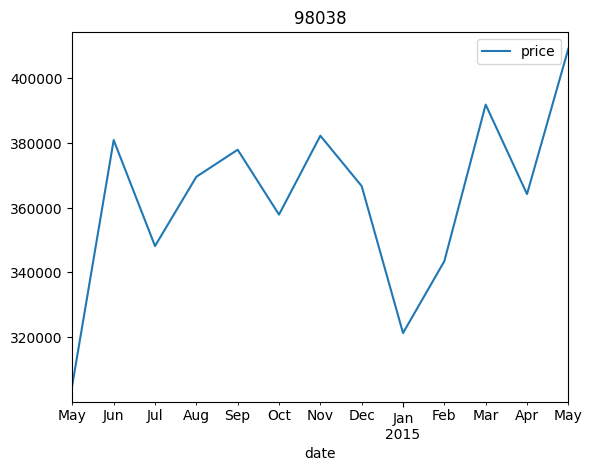

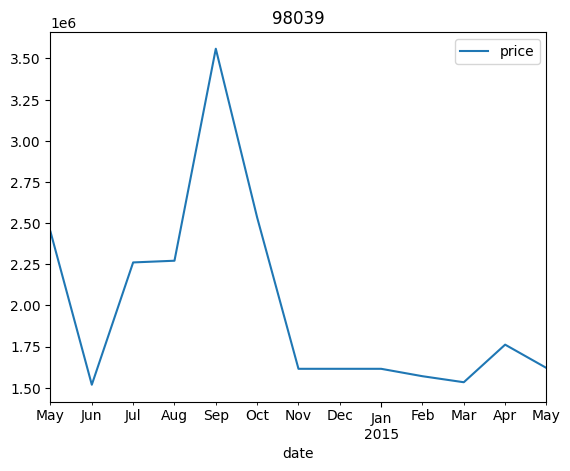

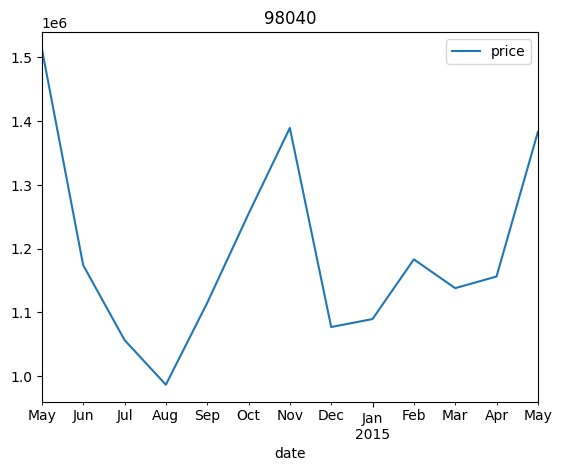

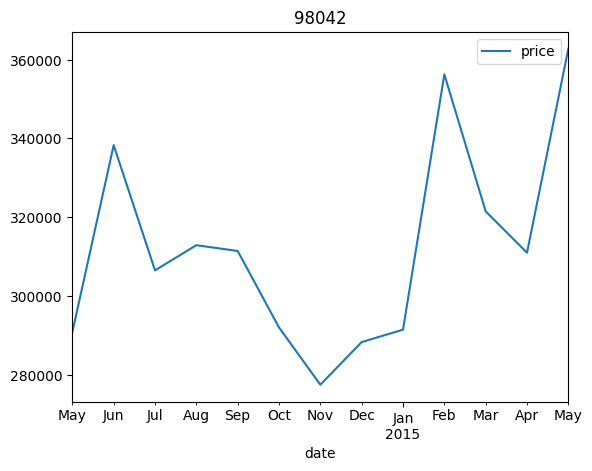

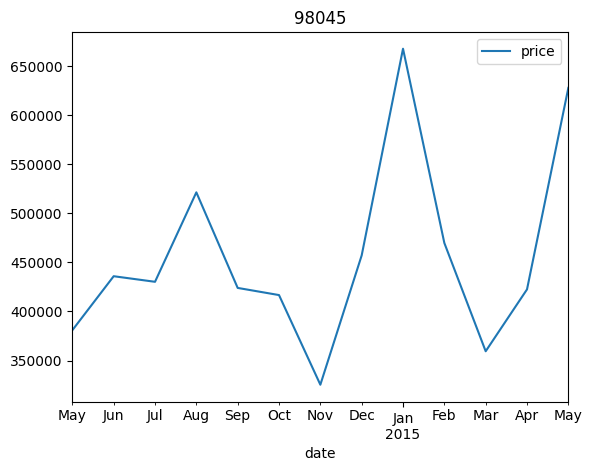

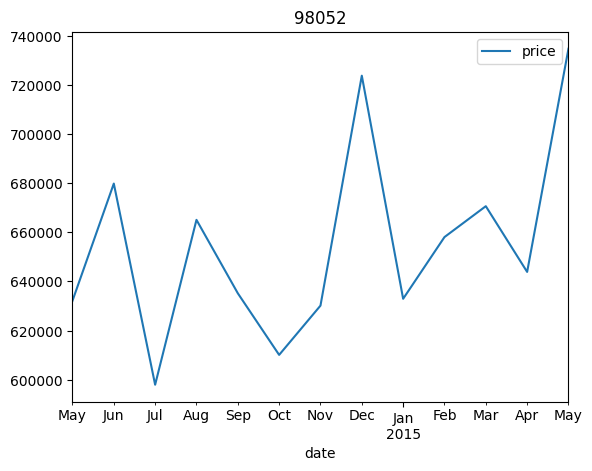

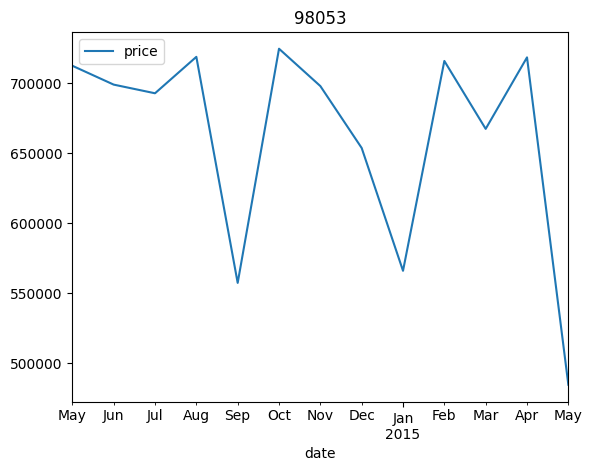

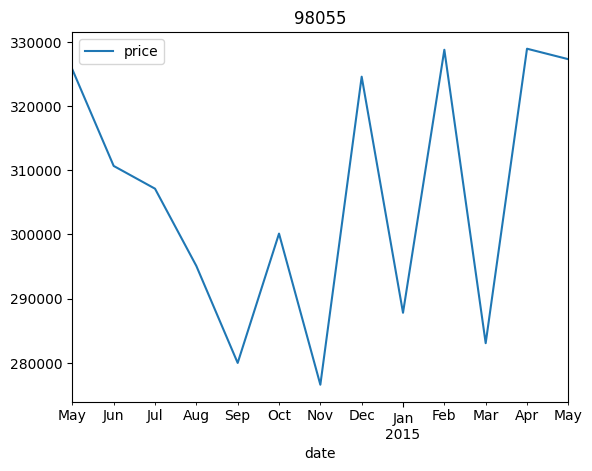

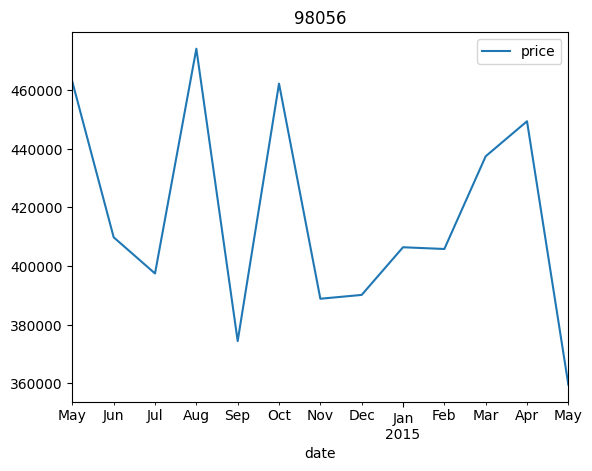

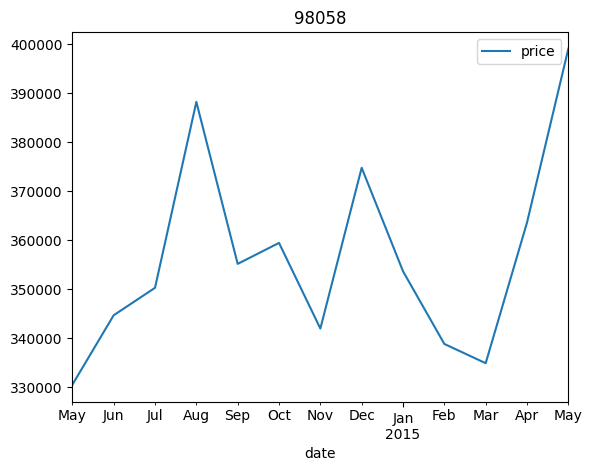

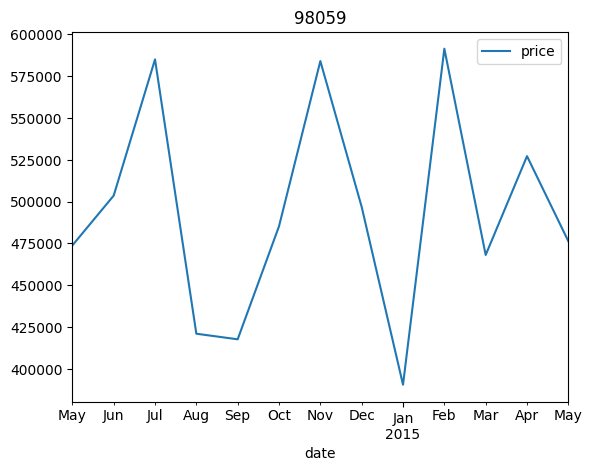

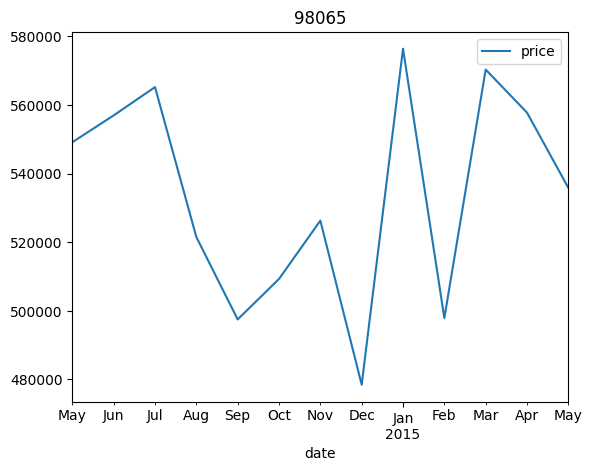

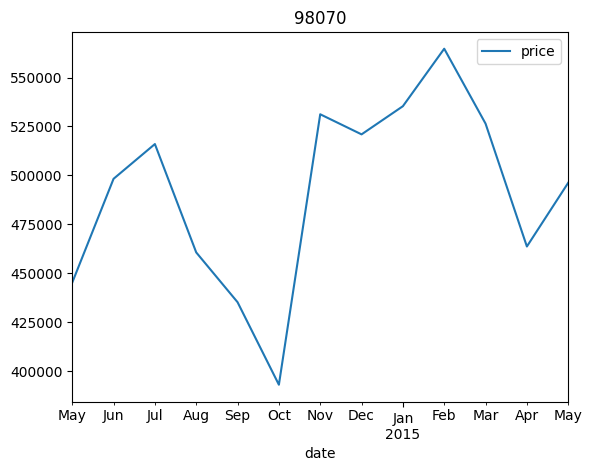

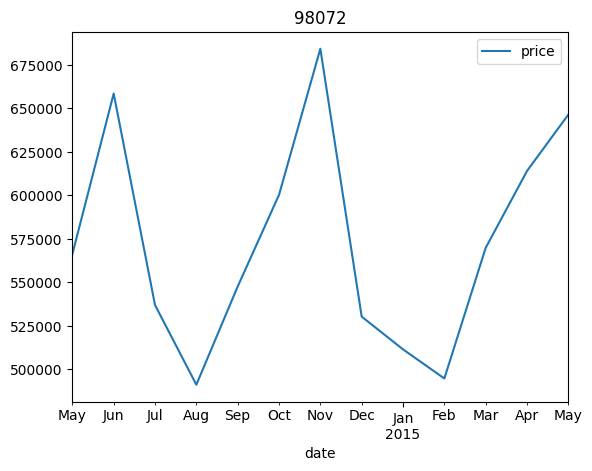

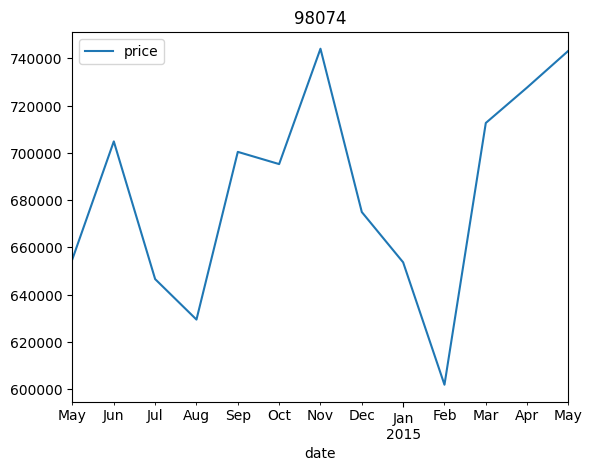

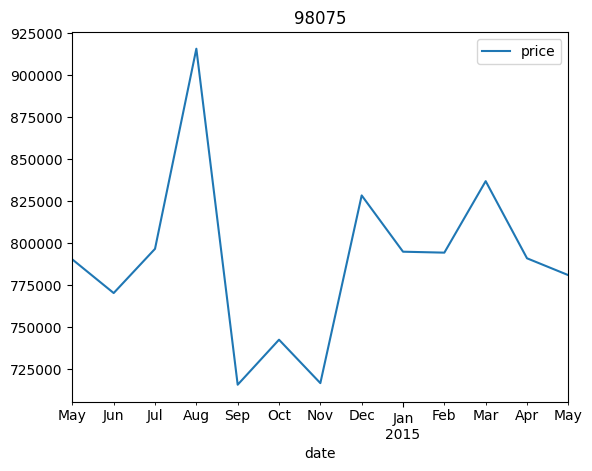

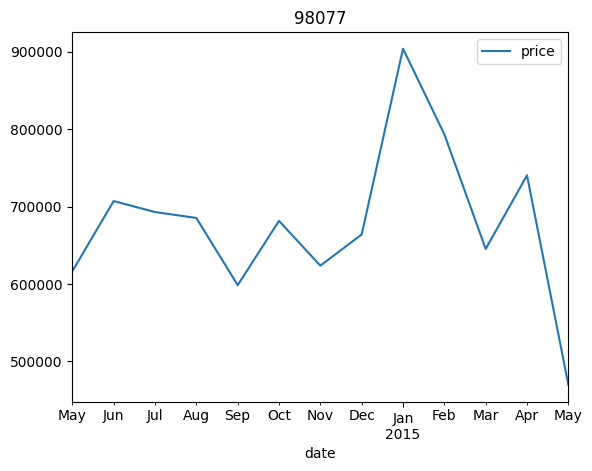

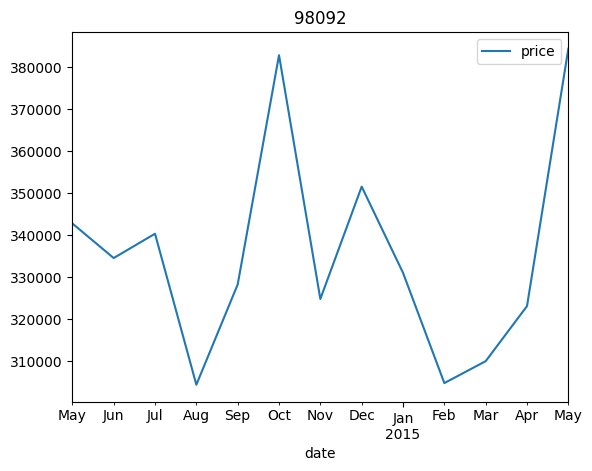

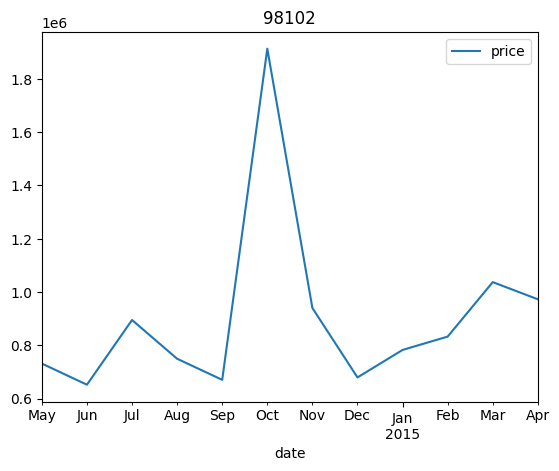

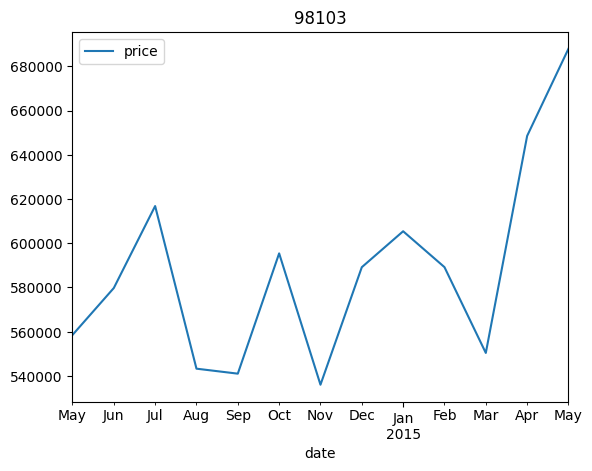

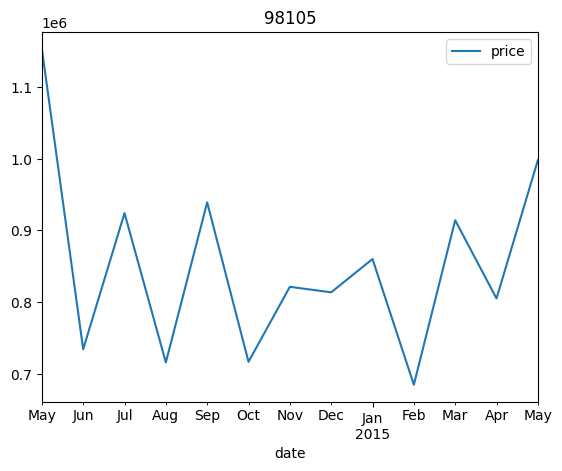

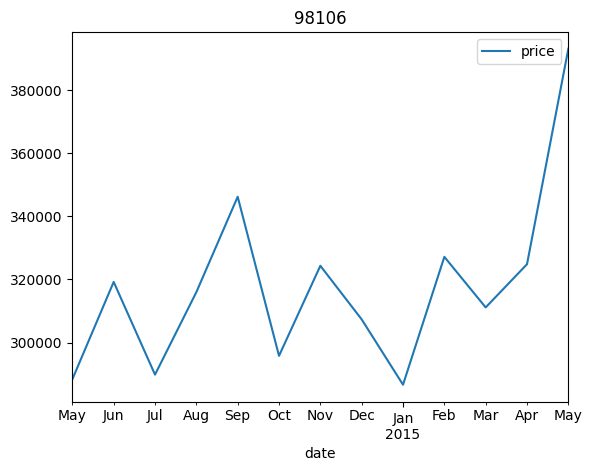

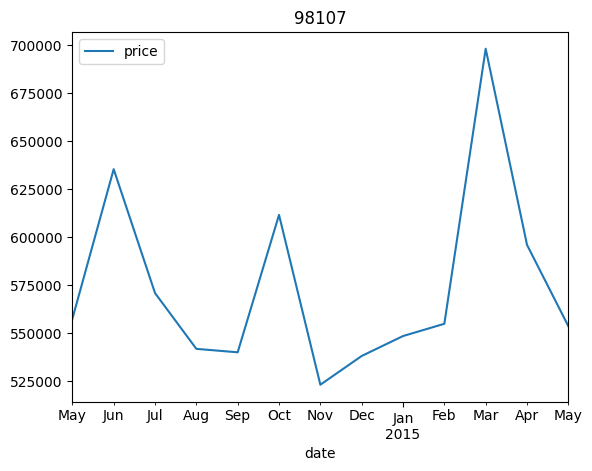

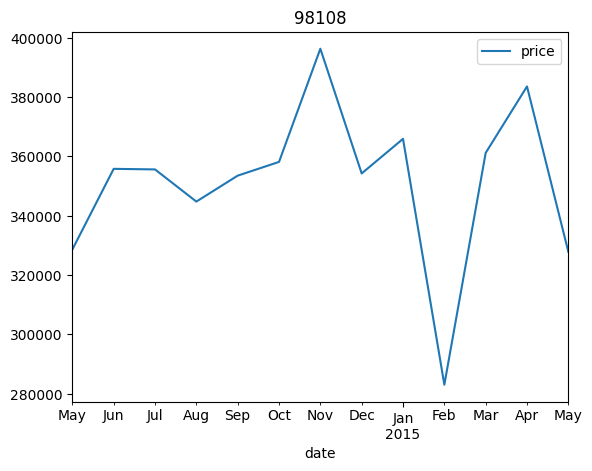

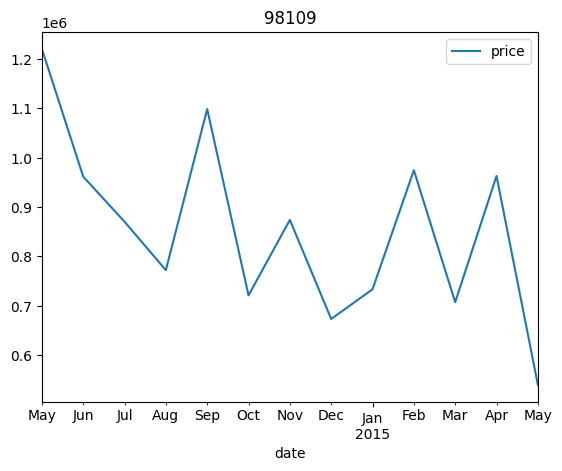

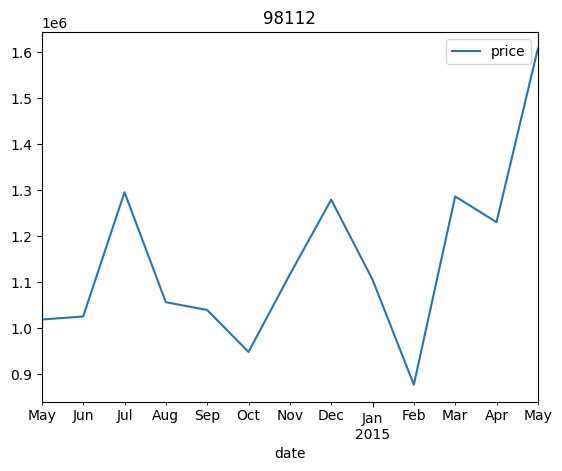

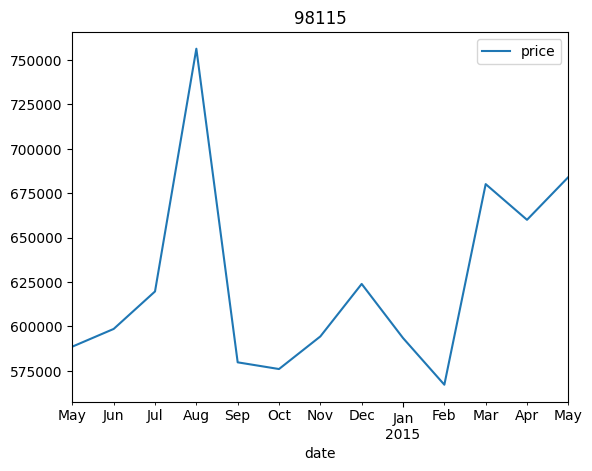

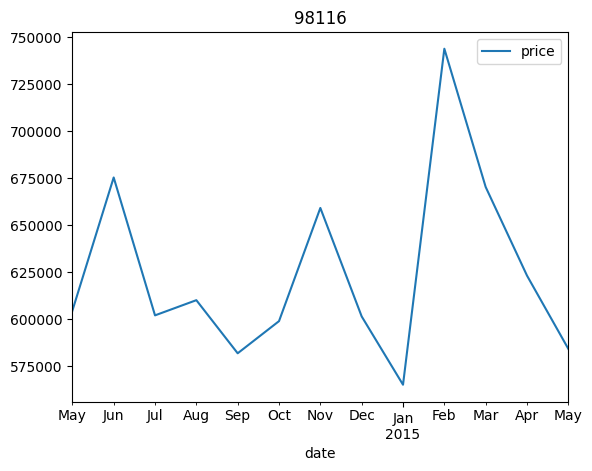

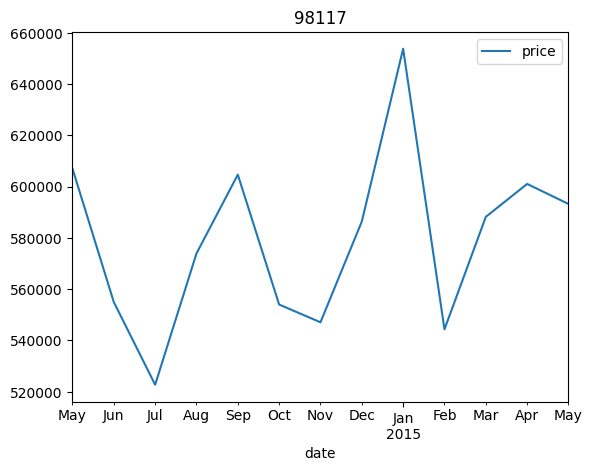

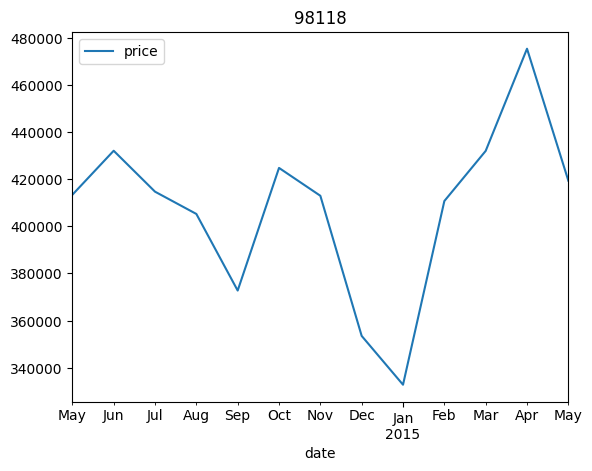

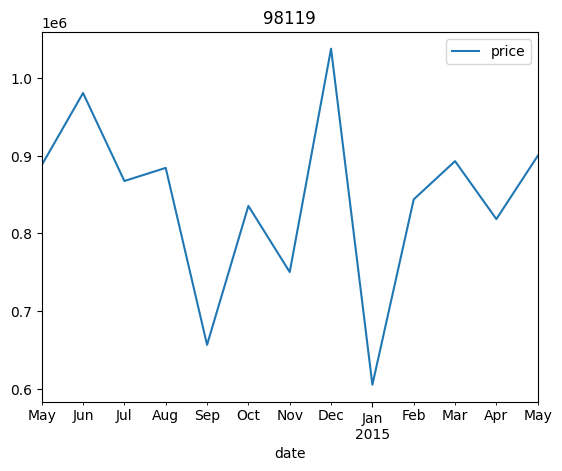

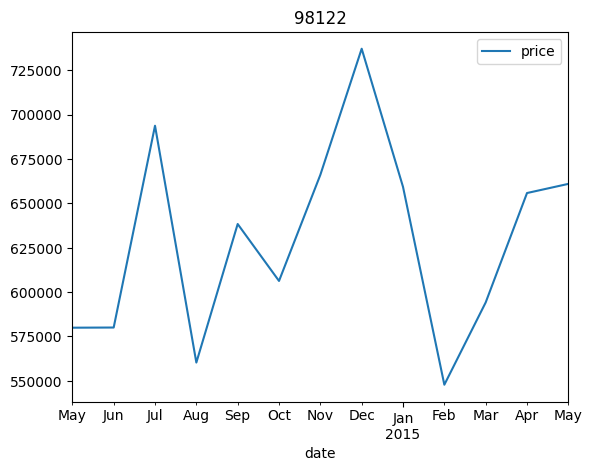

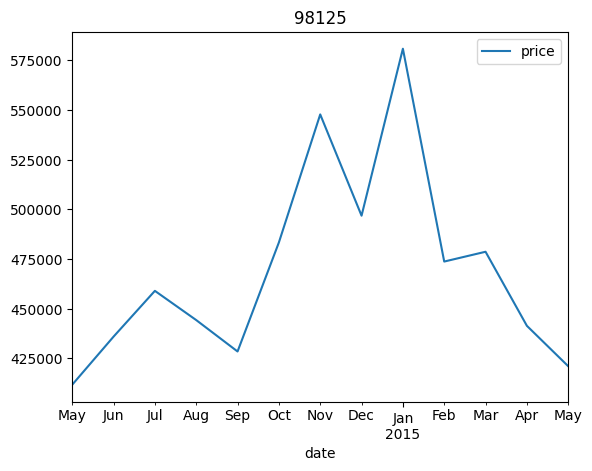

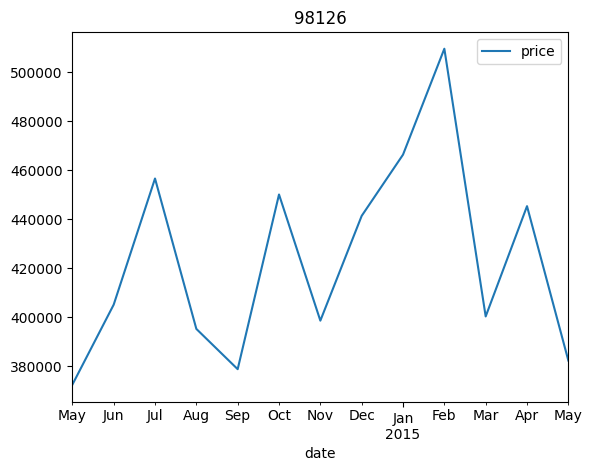

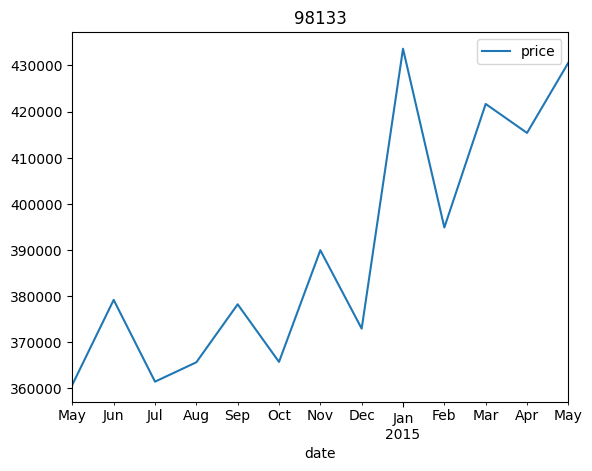

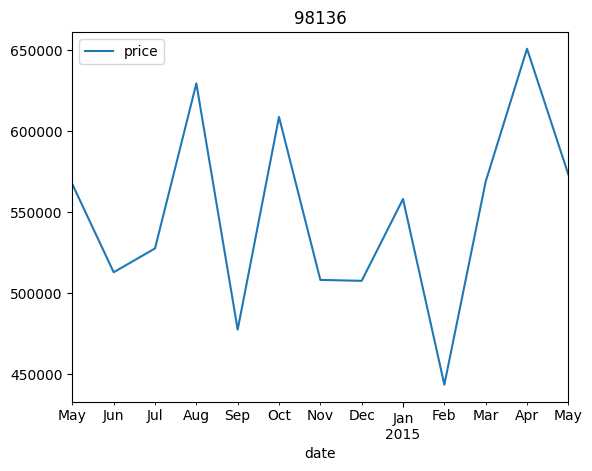

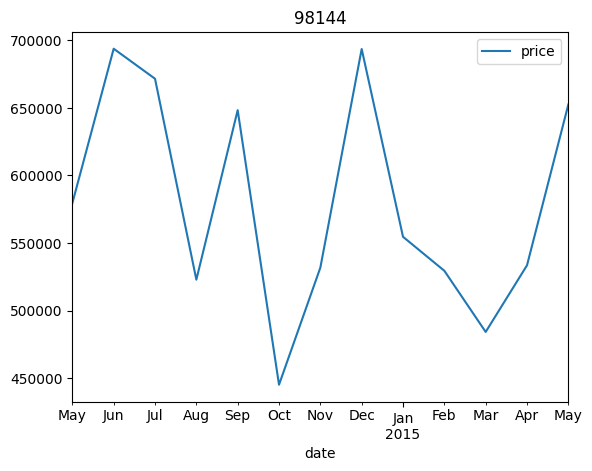

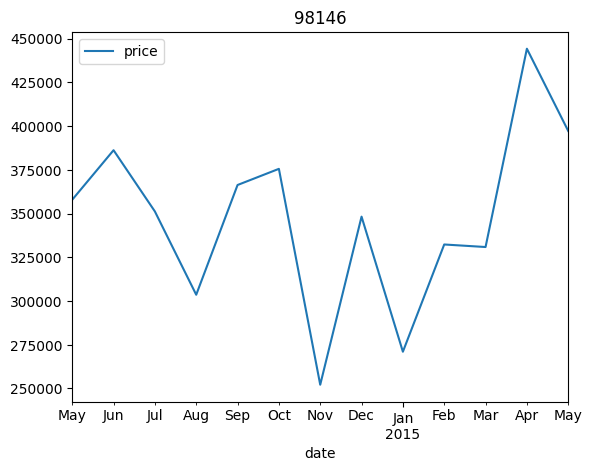

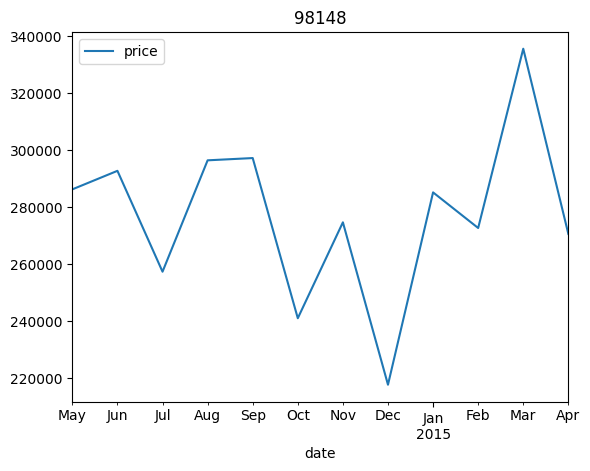

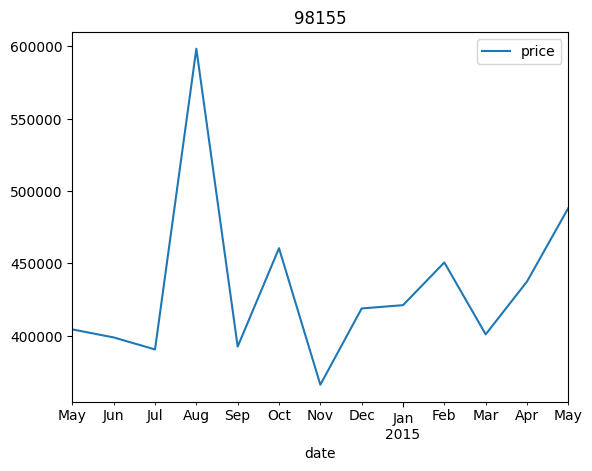

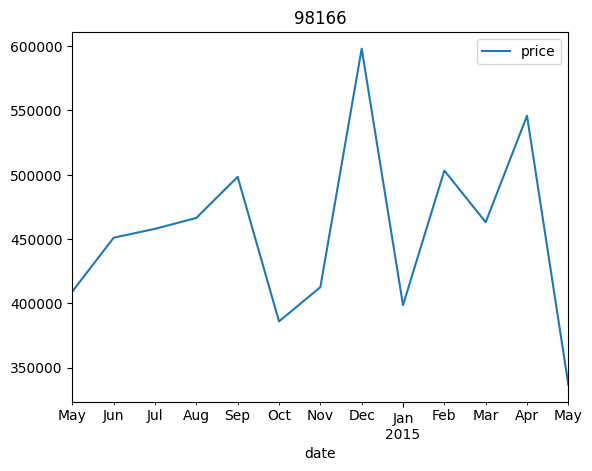

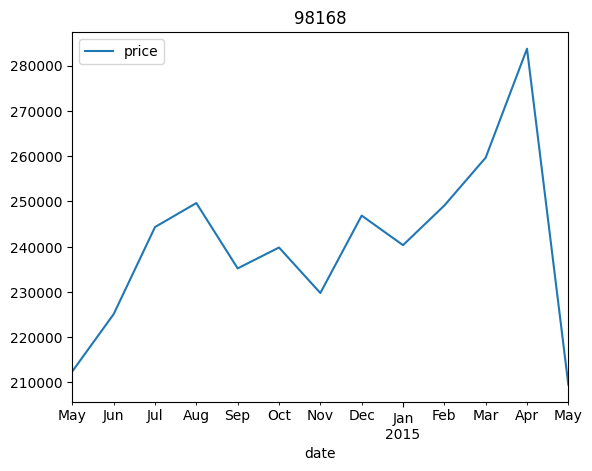

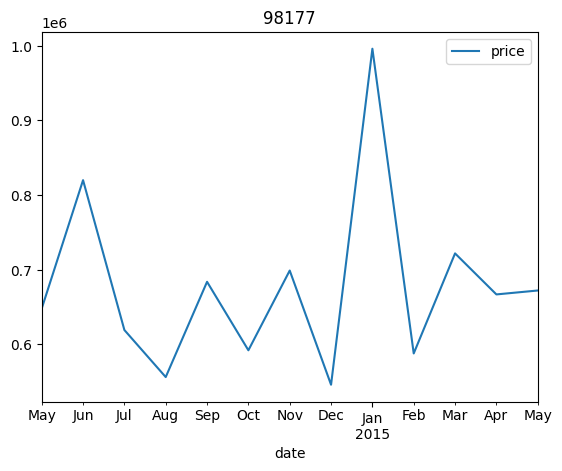

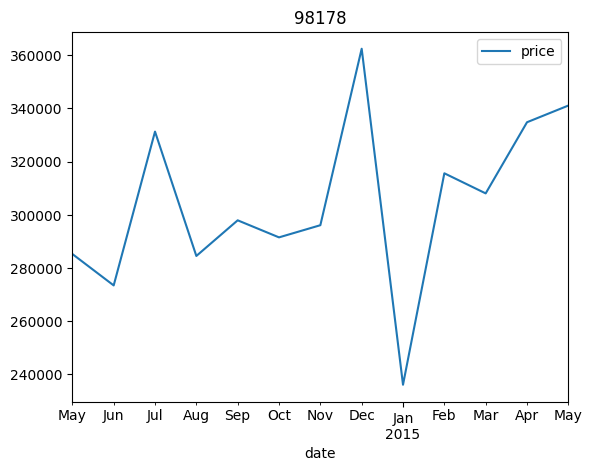

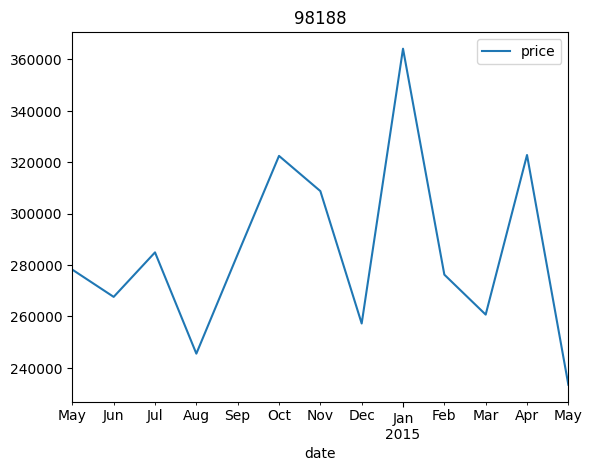

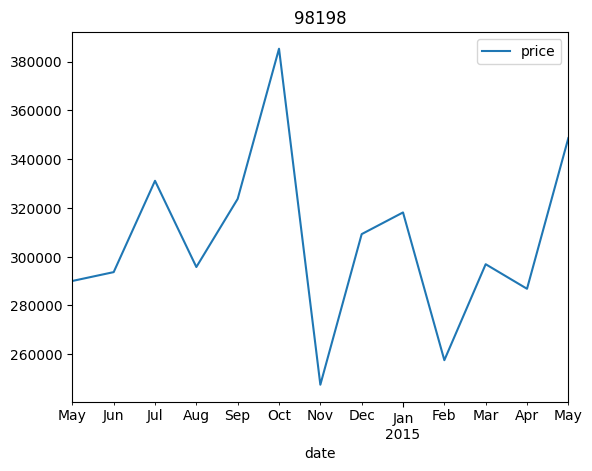

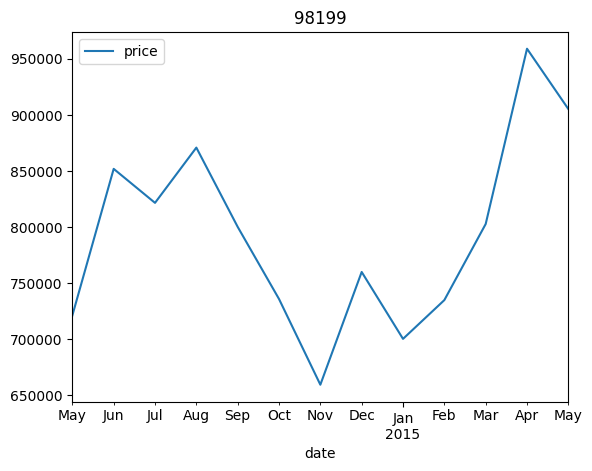

In [27]:
for df,name in zip(zip_dfs, lst):
    df.plot()
    plt.title(name)
    plt.show()

# Generating combinations of pdq and 

In [28]:
p = d = q = range(0,2)
pdq = list(itertools.product(p,d,q))
PDQS = [(x[0], x[1], x[2], 2) for x in list(itertools.product(p, d, q))]

In [29]:
pdq

[(0, 0, 0),
 (0, 0, 1),
 (0, 1, 0),
 (0, 1, 1),
 (1, 0, 0),
 (1, 0, 1),
 (1, 1, 0),
 (1, 1, 1)]

In [30]:
PDQS

[(0, 0, 0, 2),
 (0, 0, 1, 2),
 (0, 1, 0, 2),
 (0, 1, 1, 2),
 (1, 0, 0, 2),
 (1, 0, 1, 2),
 (1, 1, 0, 2),
 (1, 1, 1, 2)]

In [31]:
ans = []

for df, name in zip(zip_dfs, lst):
    for para1 in pdq:
        for para2 in PDQS:
            try:
                mod = sm.tsa.statespace.SARIMAX(df,
                                                order = para1,
                                                seasonal_order = para2,
                                                freq = 'MS',
                                                enforce_stationarity = True,
                                                enforce_invertibility = False)
                output = mod.fit()
                ans.append([name, para1, para2, output.aic])
                print('Result for {}'.format(name) + ' ARIMA {} x {}12 : AIC Calculated = {}'.format(para1, para2, output.aic))
            except:
                continue

Result for 98001 ARIMA (0, 0, 0) x (0, 0, 0, 2)12 : AIC Calculated = 365.5333972992453
Result for 98001 ARIMA (0, 0, 0) x (0, 0, 1, 2)12 : AIC Calculated = 380.4070917941682
Result for 98001 ARIMA (0, 0, 0) x (0, 1, 0, 2)12 : AIC Calculated = 263.2886018858672
Result for 98001 ARIMA (0, 0, 0) x (0, 1, 1, 2)12 : AIC Calculated = 264.5351672970702
Result for 98001 ARIMA (0, 0, 0) x (1, 0, 0, 2)12 : AIC Calculated = 321.1566948540711
Result for 98001 ARIMA (0, 0, 0) x (1, 0, 1, 2)12 : AIC Calculated = 320.7658945602411
Result for 98001 ARIMA (0, 0, 0) x (1, 1, 0, 2)12 : AIC Calculated = 265.0877143398819
Result for 98001 ARIMA (0, 0, 0) x (1, 1, 1, 2)12 : AIC Calculated = 269.0346581353047
Result for 98001 ARIMA (0, 0, 1) x (0, 0, 0, 2)12 : AIC Calculated = 360.0638136992022
Result for 98001 ARIMA (0, 0, 1) x (0, 0, 1, 2)12 : AIC Calculated = 378.32947220156325
Result for 98001 ARIMA (0, 0, 1) x (0, 1, 0, 2)12 : AIC Calculated = 260.6216030605641
Result for 98001 ARIMA (0, 0, 1) x (0, 1, 

In [34]:
result = pd.DataFrame(ans, columns = ['name','pdq','PDQS','AIC'])

# Printing AIC metric
The **Akaike Information Critera (AIC)** is a widely used measure of a statistical model. It basically quantifies 1) the goodness of fit, and 2) the simplicity/parsimony, of the model into a single statistic.

The lower AIC is generally “better”. 

In [35]:
best_para = result.loc[result.groupby("name")["AIC"].idxmin()]

In [36]:
best_para

name        pdq          PDQS        AIC
50    98001  (1, 1, 0)  (0, 1, 0, 2) 241.157854
82    98002  (0, 1, 0)  (0, 1, 0, 2) 239.194139
146   98003  (0, 1, 0)  (0, 1, 0, 2) 248.504747
211   98004  (0, 1, 0)  (0, 1, 1, 2) 282.044607
274   98005  (0, 1, 0)  (0, 1, 0, 2) 261.334716
338   98006  (0, 1, 0)  (0, 1, 0, 2) 280.269788
406   98007  (0, 1, 0)  (1, 1, 0, 2) 270.809384
470   98008  (0, 1, 0)  (1, 1, 0, 2) 274.655320
534   98010  (0, 1, 0)  (1, 1, 0, 2) 231.670967
598   98011  (0, 1, 0)  (1, 1, 0, 2) 256.037505
659   98014  (0, 1, 0)  (0, 1, 1, 2) 265.715736
722   98019  (0, 1, 0)  (0, 1, 0, 2) 236.756874
790   98022  (0, 1, 0)  (1, 1, 0, 2) 247.786216
882   98023  (1, 1, 0)  (0, 1, 0, 2) 236.320848
915   98024  (0, 1, 0)  (0, 1, 1, 2) 288.400936
978   98027  (0, 1, 0)  (0, 1, 0, 2) 271.868415
1046  98028  (0, 1, 0)  (1, 1, 0, 2) 248.823646
1106  98029  (0, 1, 0)  (0, 1, 0, 2) 257.537512
1170  98030  (0, 1, 0)  (0, 1, 0, 2) 238.165489
1235  98031  (0, 1, 0)  (0, 1, 1, 2) 244.968046
1298  98032  (0, 1, 0)  (0, 1, 0, 2) 238.970811
1363  98033  (0, 1, 0)  (0, 1, 1, 2) 266.017484
1427  98034  (0, 1, 0)  (0, 1, 1, 2) 268.052713
1491  98038  (0, 1, 0)  (0, 1, 1, 2) 245.995200
1558  98039  (0, 1, 0)  (1, 1, 0, 2) 302.070598
1622  98040  (0, 1, 0)  (1, 1, 0, 2) 278.163333
1725  98042  (1, 1, 1)  (1, 0, 1, 2)  10.000000
1751  98045  (0, 1, 0)  (1, 1, 1, 2) 275.046171
1810  98052  (0, 1, 0)  (0, 1, 0, 2) 256.640025
1874  98053  (0, 1, 0)  (0, 1, 0, 2) 267.707173
1938  98055  (0, 1, 0)  (0, 1, 0, 2) 229.203786
2034  98056  (1, 1, 0)  (0, 1, 0, 2) 250.166902
2066  98058  (0, 1, 0)  (0, 1, 0, 2) 238.259193
2130  98059  (0, 1, 0)  (0, 1, 0, 2) 271.415540
2194  98065  (0, 1, 0)  (0, 1, 0, 2) 250.064498
2258  98070  (0, 1, 0)  (0, 1, 0, 2) 258.137401
2323  98072  (0, 1, 0)  (0, 1, 1, 2) 258.791265
2415  98074  (1, 0, 1)  (1, 1, 1, 2)  10.000000
2463  98075  (0, 1, 1)  (1, 1, 1, 2) 259.948450
2514  98077  (0, 1, 0)  (0, 1, 0, 2) 273.381624
2578  98092  (0, 1, 0)  (0, 1, 0, 2) 247.656555
2650  98102  (0, 1, 1)  (0, 1, 0, 2) 271.849925
2706  98103  (0, 1, 0)  (0, 1, 0, 2) 256.379751
2778  98105  (0, 1, 1)  (0, 1, 0, 2) 263.703321
2834  98106  (0, 1, 0)  (0, 1, 0, 2) 246.786451
2902  98107  (0, 1, 0)  (1, 1, 0, 2) 261.949181
2962  98108  (0, 1, 0)  (0, 1, 0, 2) 252.007358
3070  98109  (1, 1, 1)  (1, 1, 0, 2) 278.980584
3090  98112  (0, 1, 0)  (0, 1, 0, 2) 283.075534
3167  98115  (0, 1, 1)  (1, 1, 1, 2) 260.687972
3219  98116  (0, 1, 0)  (0, 1, 1, 2) 264.197517
3318  98117  (1, 1, 0)  (1, 1, 0, 2) 258.216664
3346  98118  (0, 1, 0)  (0, 1, 0, 2) 253.134039
3410  98119  (0, 1, 0)  (0, 1, 0, 2) 277.727464
3474  98122  (0, 1, 0)  (0, 1, 0, 2) 264.363679
3538  98125  (0, 1, 0)  (0, 1, 0, 2) 252.058456
3602  98126  (0, 1, 0)  (0, 1, 0, 2) 255.765029
3670  98133  (0, 1, 0)  (1, 1, 0, 2) 232.251642
3762  98136  (1, 1, 0)  (0, 1, 0, 2) 263.870353
3795  98144  (0, 1, 0)  (0, 1, 1, 2) 271.598042
3862  98146  (0, 1, 0)  (1, 1, 0, 2) 256.114932
3922  98148  (0, 1, 0)  (0, 1, 0, 2) 220.914667
4018  98155  (1, 1, 0)  (0, 1, 0, 2) 261.589782
4051  98166  (0, 1, 0)  (0, 1, 1, 2) 267.839125
4119  98168  (0, 1, 0)  (1, 1, 1, 2) 236.530457
4182  98177  (0, 1, 0)  (1, 1, 0, 2) 276.864087
4242  98178  (0, 1, 0)  (0, 1, 0, 2) 252.931565
4314  98188  (0, 1, 1)  (0, 1, 0, 2) 258.086130
4370  98198  (0, 1, 0)  (0, 1, 0, 2) 258.647104
4434  98199  (0, 1, 0)  (0, 1, 0, 2) 260.921724

# Plug the optimal parameter values into a new SARIMAX model to have a deeper look

In [37]:
for name, pdq, PDQS, df in zip(best_para['name'], best_para['pdq'], best_para['PDQS'], zip_dfs): 
    ARIMA_MODEL = sm.tsa.SARIMAX(df, 
                           order = pdq,
                           seasonal_order = PDQS,
                           freq = 'MS',
                           enforce_stationarity = True,
                           enforce_invertibility = False)
    
    output = ARIMA_MODEL.fit()
    print('SARIMA Model Result for {}'.format(name))
    print(output.summary().tables[1])                      

SARIMA Model Result for 98001
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2160      0.296      0.730      0.465      -0.364       0.796
sigma2      1.251e+09   6.34e-11   1.97e+19      0.000    1.25e+09    1.25e+09
SARIMA Model Result for 98002
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      8.679e+08   4.72e+08      1.839      0.066    -5.7e+07    1.79e+09
SARIMA Model Result for 98003
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      2.202e+09   1.32e+09      1.668      0.095   -3.86e+08    4.79e+09
SARIMA Model Result for 98004
                 coef    std err          z      P>|z|      [0.025      0.975]
-----------

SARIMA Model Result for 98031
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.S.L2       -0.3333      0.322     -1.036      0.300      -0.964       0.297
sigma2       2.68e+09   4.76e-12   5.63e+20      0.000    2.68e+09    2.68e+09
SARIMA Model Result for 98032
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      8.487e+08   3.47e+08      2.446      0.014    1.69e+08    1.53e+09
SARIMA Model Result for 98033
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.S.L2       -0.3092      0.242     -1.278      0.201      -0.783       0.165
sigma2      1.263e+10   1.33e-12   9.48e+21      0.000    1.26e+10    1.26e+10
SARIMA Model Result for 98034
           

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      3.498e+09   1.27e+09      2.745      0.006       1e+09       6e+09
SARIMA Model Result for 98119
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      4.092e+10   1.46e+10      2.809      0.005    1.24e+10    6.95e+10
SARIMA Model Result for 98122
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      1.075e+10   6.41e+09      1.677      0.094   -1.82e+09    2.33e+10
SARIMA Model Result for 98125
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      3.142e+09   1.88e+09      1.6

# Making dynamic forecast from 2015-01-01 and comparing with real values

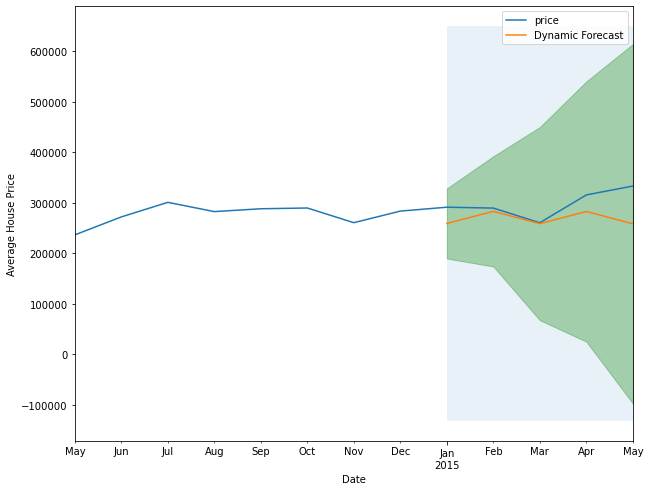

The Mean Squared Error of our forecasts is 39311.38 at zipcode 98001


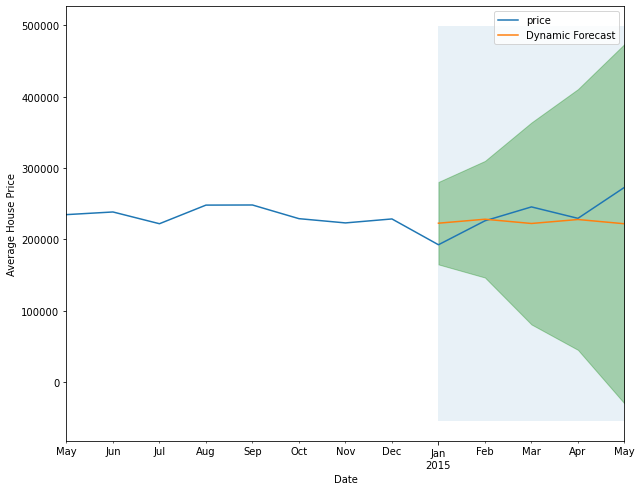

The Mean Squared Error of our forecasts is 28483.03 at zipcode 98002


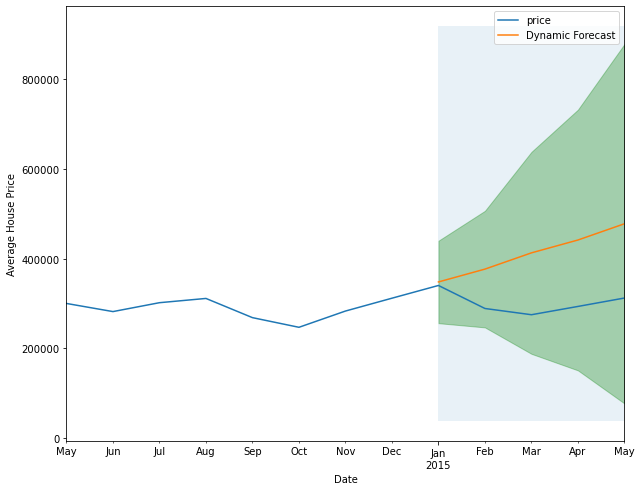

The Mean Squared Error of our forecasts is 123480.53 at zipcode 98003


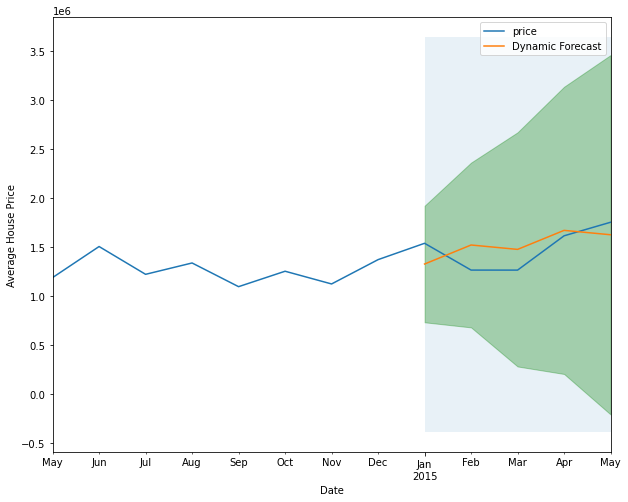

The Mean Squared Error of our forecasts is 186639.54 at zipcode 98004


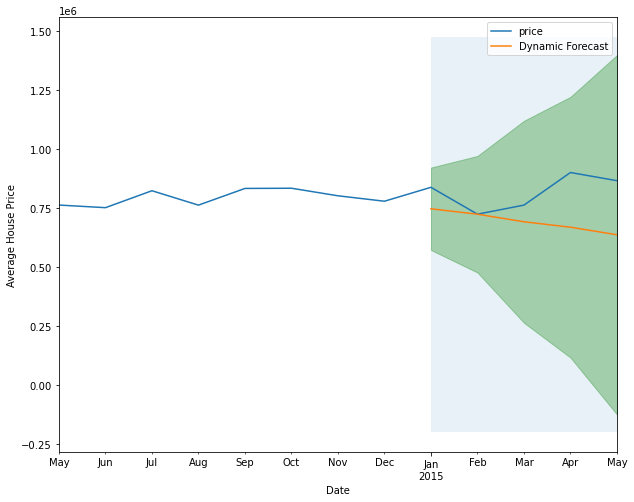

The Mean Squared Error of our forecasts is 154574.78 at zipcode 98005


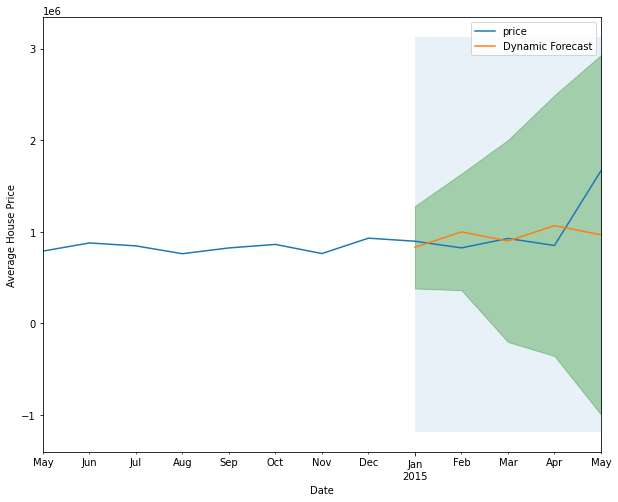

The Mean Squared Error of our forecasts is 337361.18 at zipcode 98006


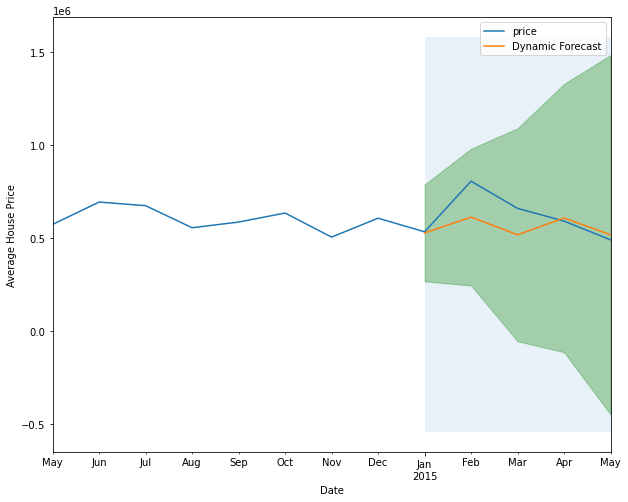

The Mean Squared Error of our forecasts is 108163.24 at zipcode 98007


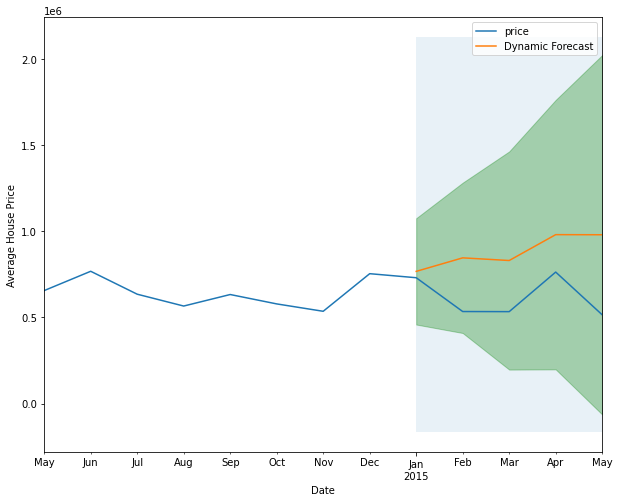

The Mean Squared Error of our forecasts is 299907.12 at zipcode 98008


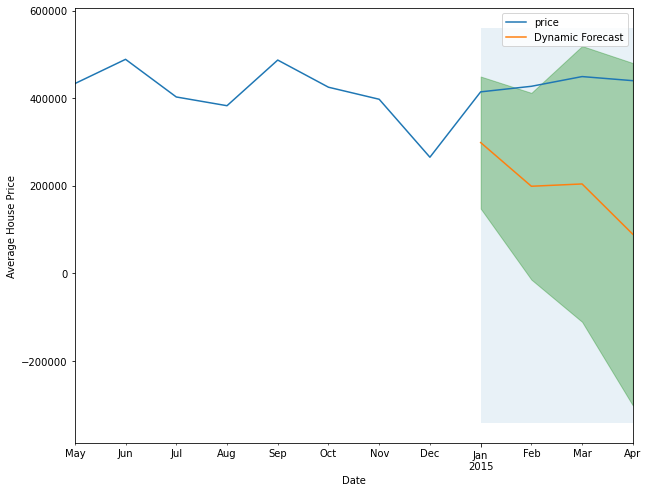

The Mean Squared Error of our forecasts is 249252.69 at zipcode 98010


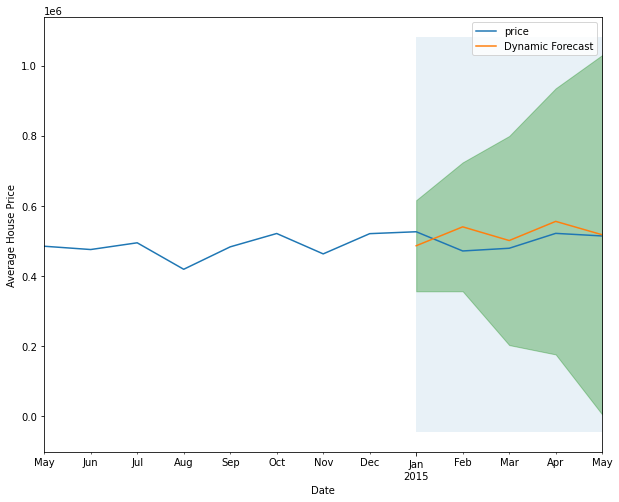

The Mean Squared Error of our forecasts is 40044.04 at zipcode 98011


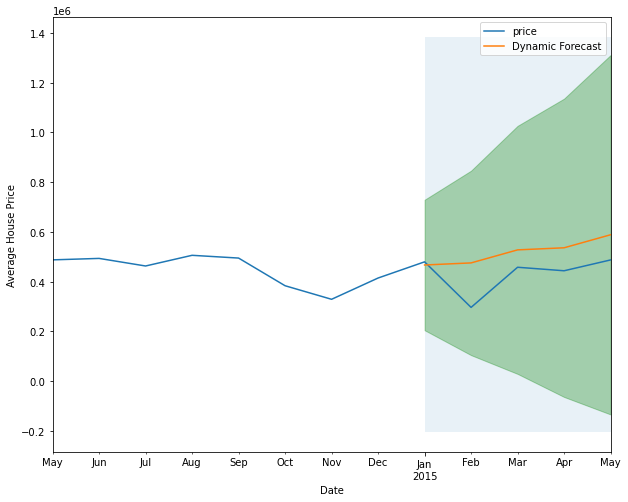

The Mean Squared Error of our forecasts is 105637.82 at zipcode 98014


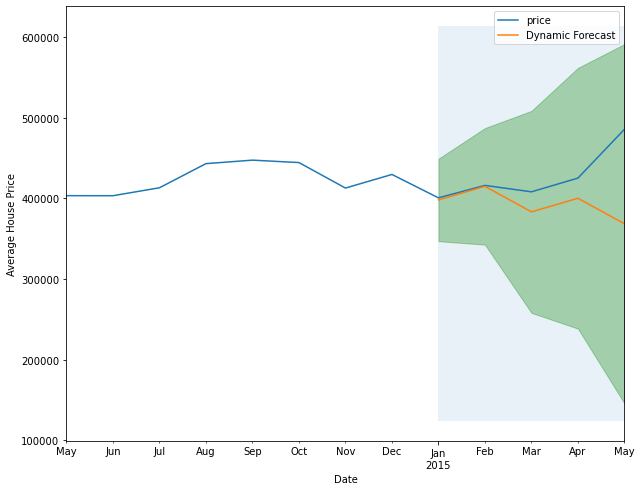

The Mean Squared Error of our forecasts is 54719.7 at zipcode 98019


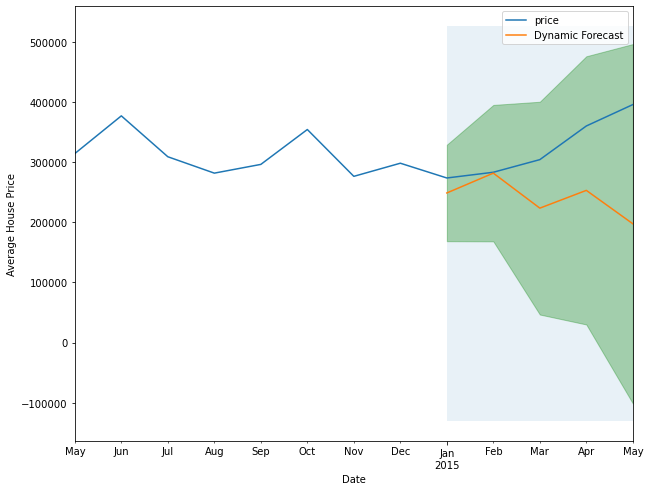

The Mean Squared Error of our forecasts is 107700.37 at zipcode 98022


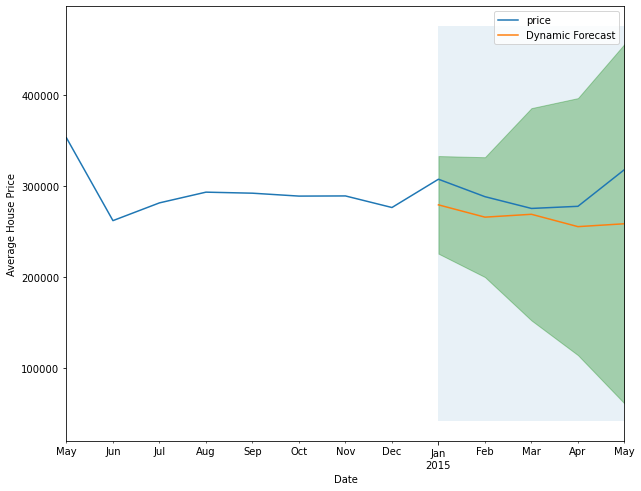

The Mean Squared Error of our forecasts is 32838.79 at zipcode 98023


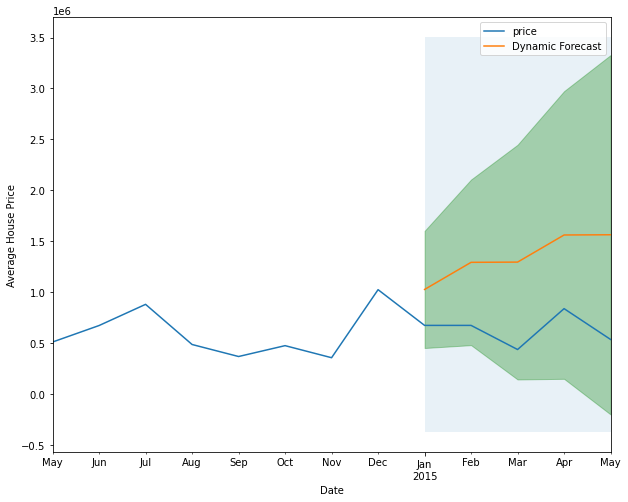

The Mean Squared Error of our forecasts is 751375.49 at zipcode 98024


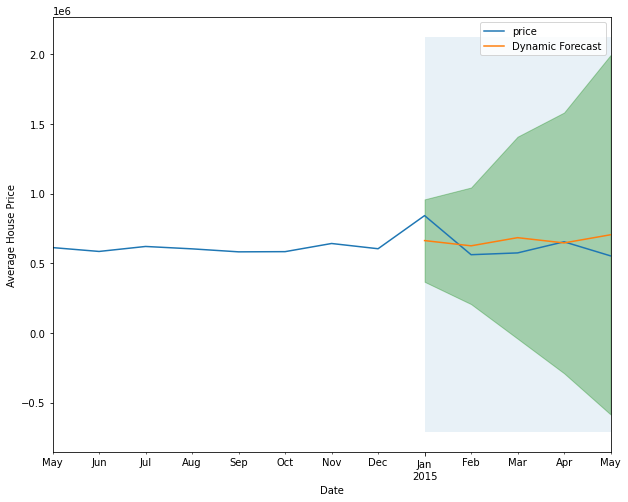

The Mean Squared Error of our forecasts is 119295.24 at zipcode 98027


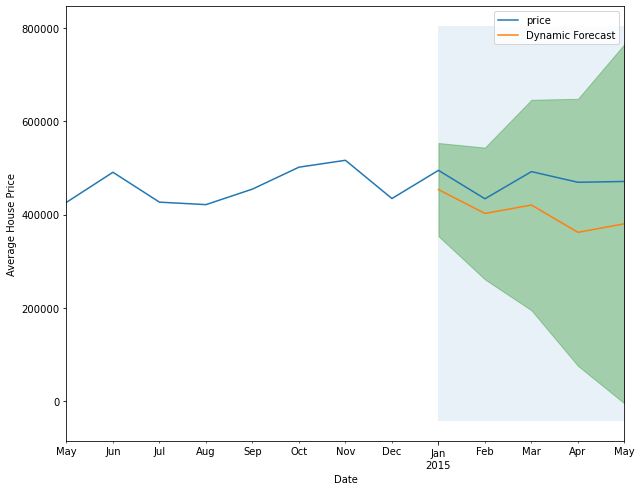

The Mean Squared Error of our forecasts is 74122.69 at zipcode 98028


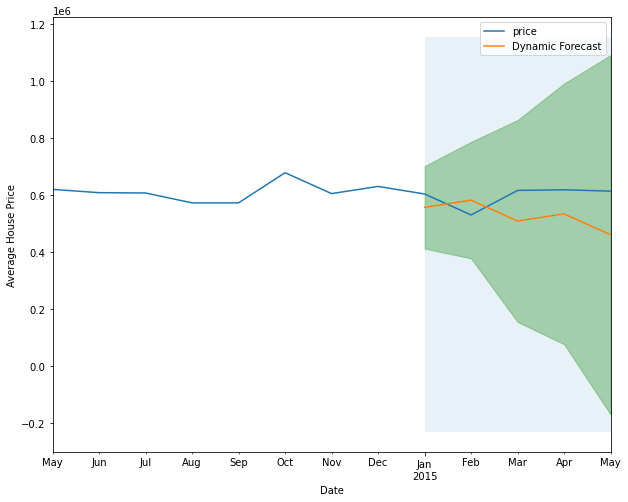

The Mean Squared Error of our forecasts is 96843.08 at zipcode 98029


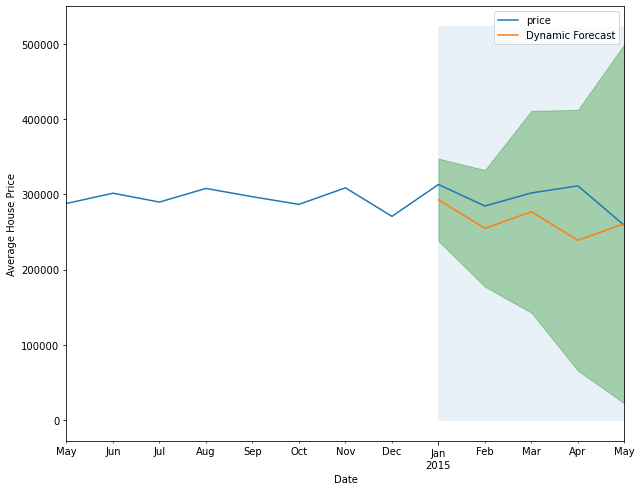

The Mean Squared Error of our forecasts is 37886.86 at zipcode 98030


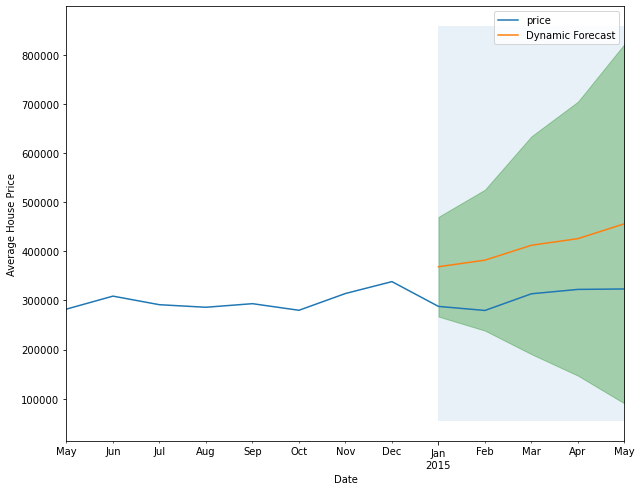

The Mean Squared Error of our forecasts is 104948.81 at zipcode 98031


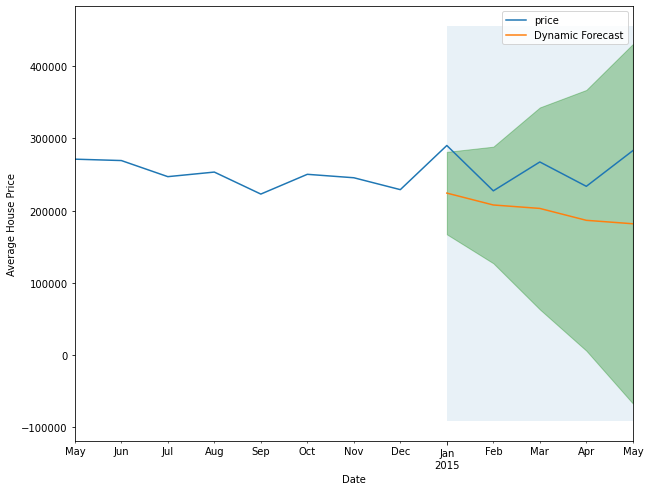

The Mean Squared Error of our forecasts is 65327.01 at zipcode 98032


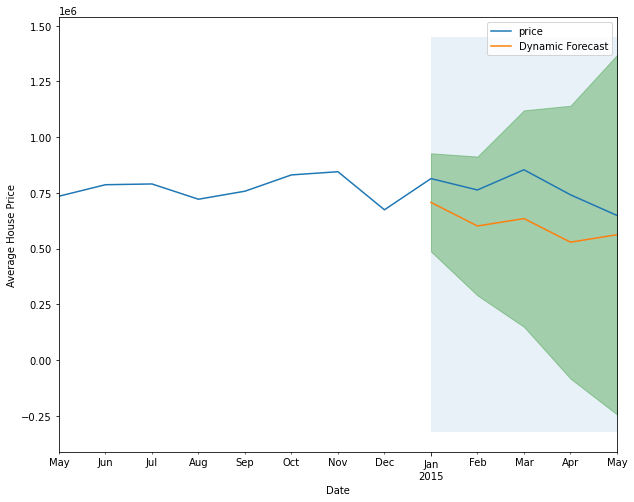

The Mean Squared Error of our forecasts is 166226.95 at zipcode 98033


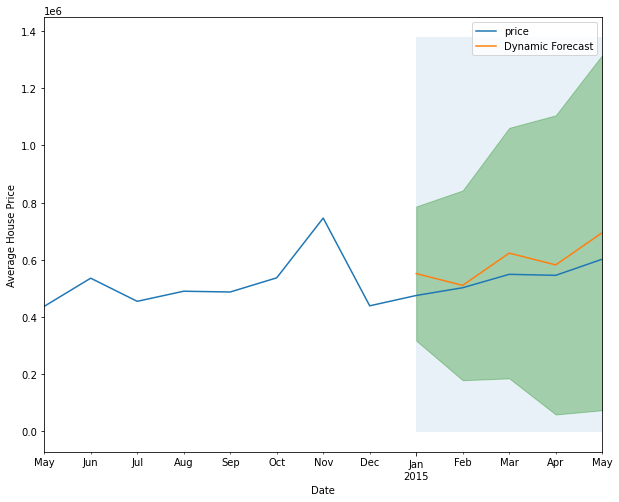

The Mean Squared Error of our forecasts is 65486.81 at zipcode 98034


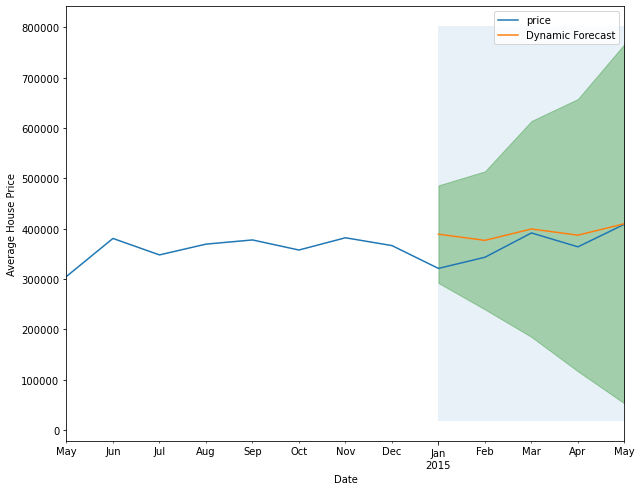

The Mean Squared Error of our forecasts is 35636.17 at zipcode 98038


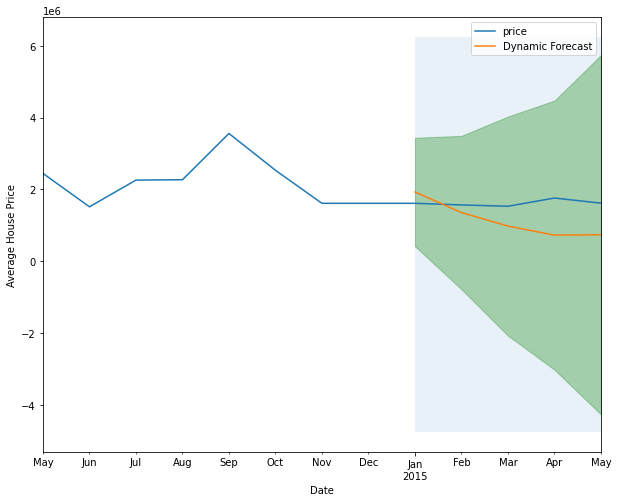

The Mean Squared Error of our forecasts is 676716.82 at zipcode 98039


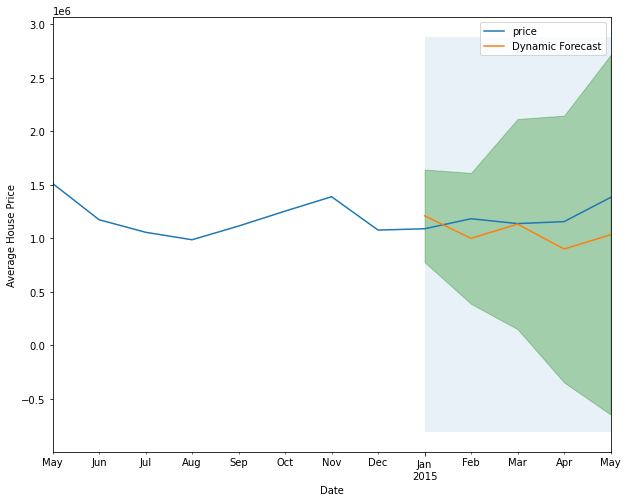

The Mean Squared Error of our forecasts is 216766.54 at zipcode 98040


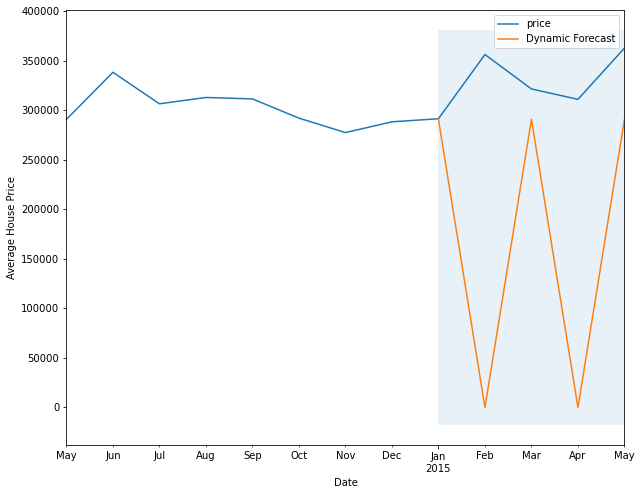

The Mean Squared Error of our forecasts is 214361.3 at zipcode 98042


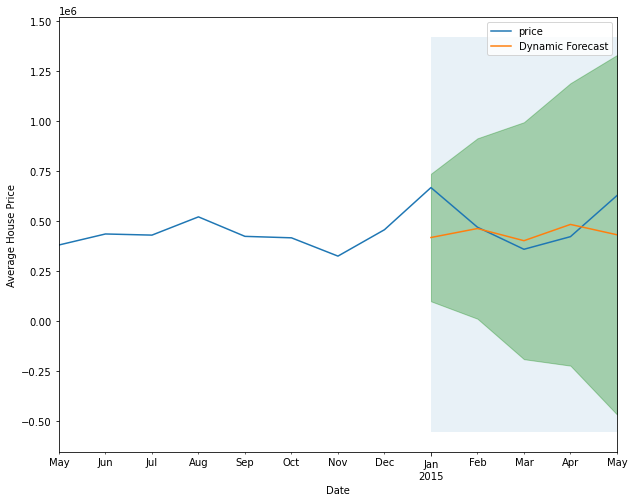

The Mean Squared Error of our forecasts is 145671.08 at zipcode 98045


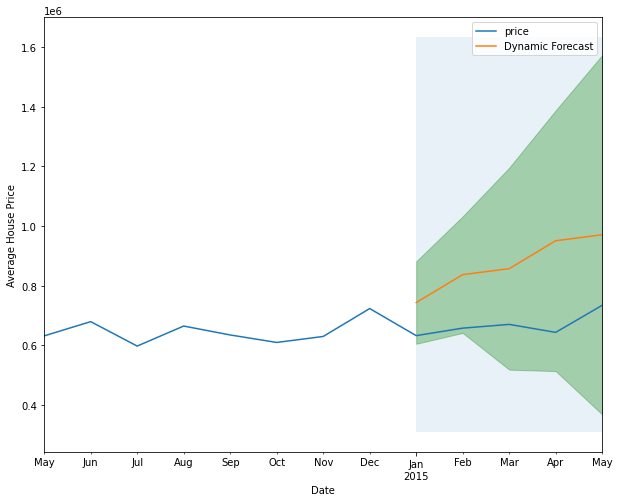

The Mean Squared Error of our forecasts is 214174.37 at zipcode 98052


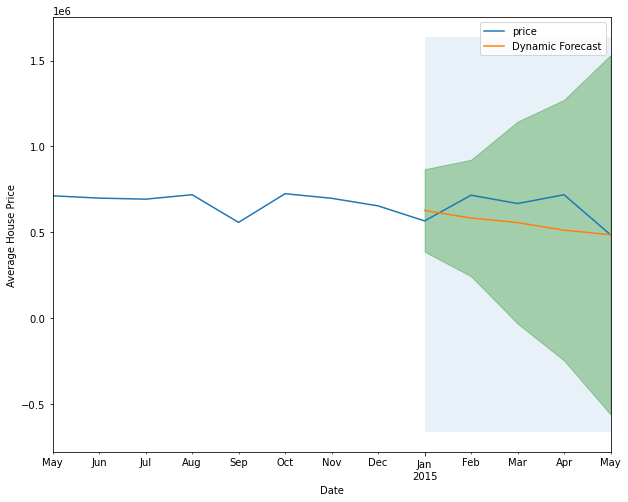

The Mean Squared Error of our forecasts is 123574.76 at zipcode 98053


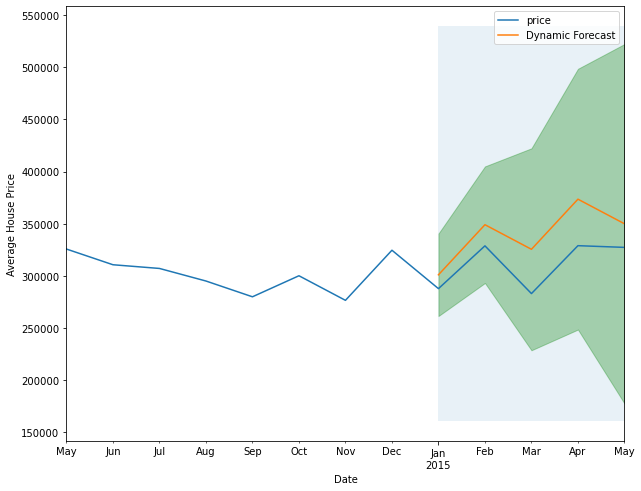

The Mean Squared Error of our forecasts is 31275.77 at zipcode 98055


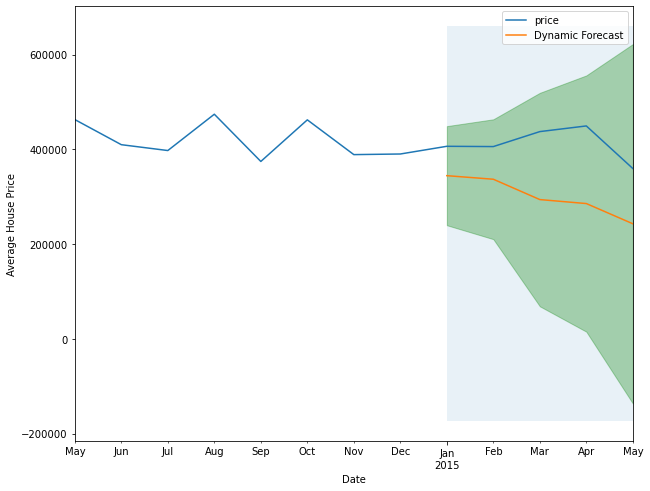

The Mean Squared Error of our forecasts is 117989.05 at zipcode 98056


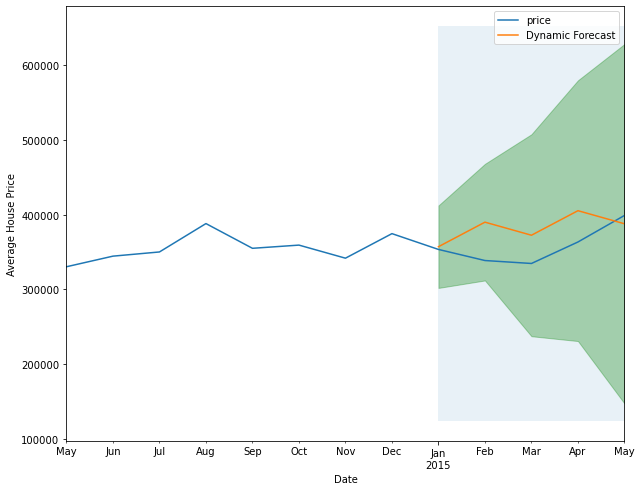

The Mean Squared Error of our forecasts is 34472.37 at zipcode 98058


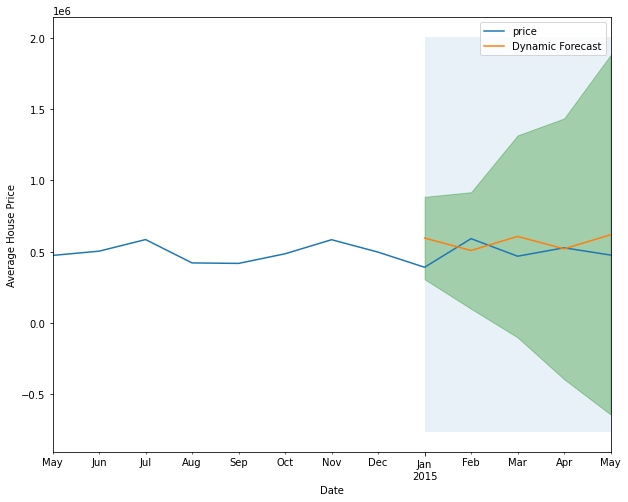

The Mean Squared Error of our forecasts is 133026.85 at zipcode 98059


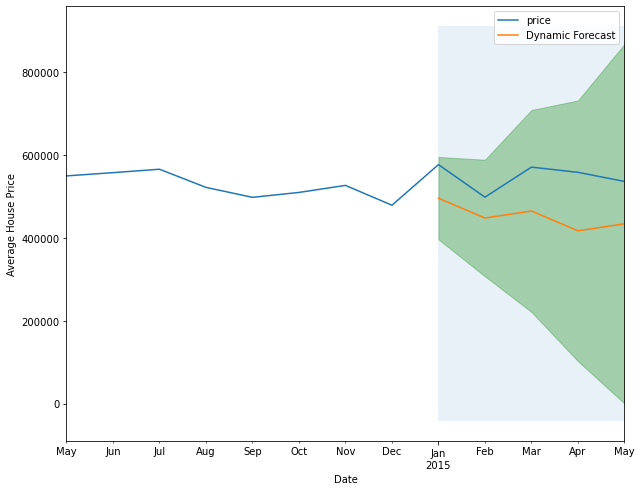

The Mean Squared Error of our forecasts is 100597.28 at zipcode 98065


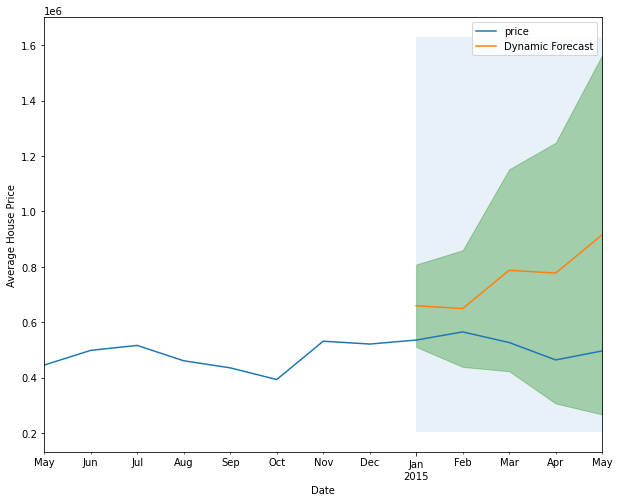

The Mean Squared Error of our forecasts is 270160.15 at zipcode 98070


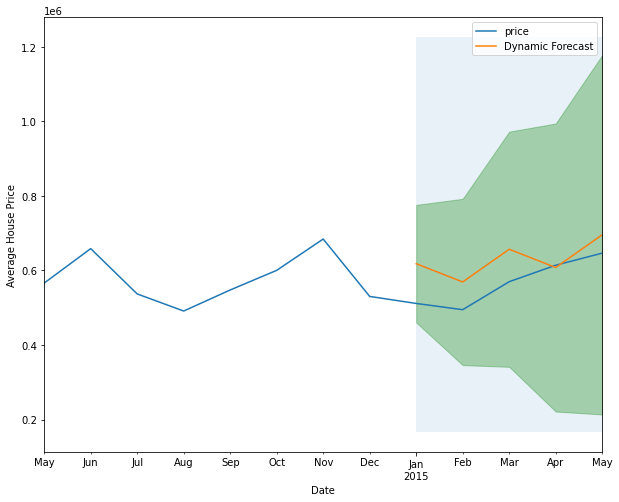

The Mean Squared Error of our forecasts is 73390.93 at zipcode 98072


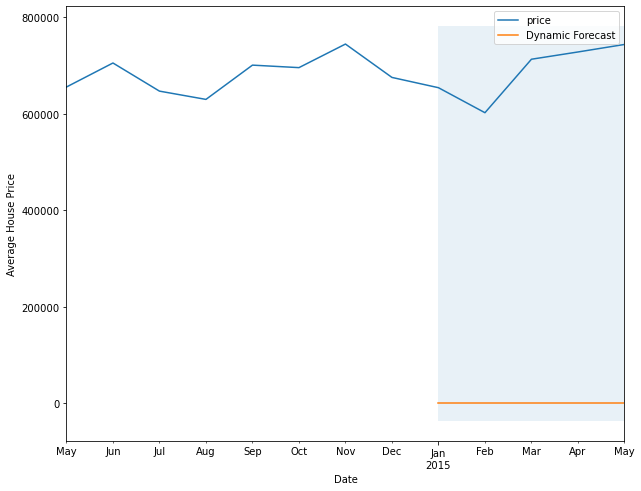

The Mean Squared Error of our forecasts is 689842.14 at zipcode 98074


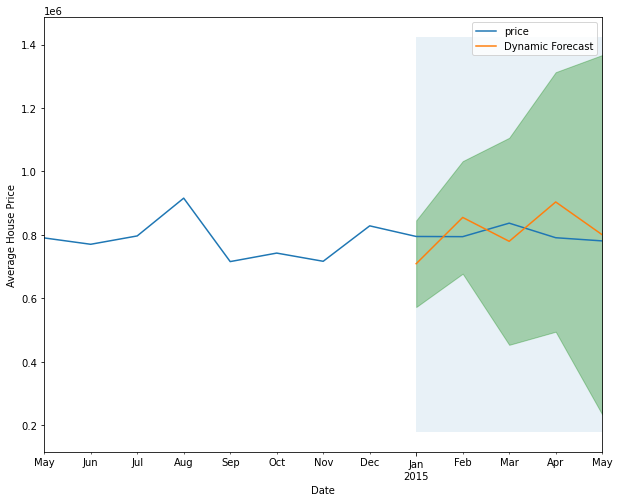

The Mean Squared Error of our forecasts is 74055.25 at zipcode 98075


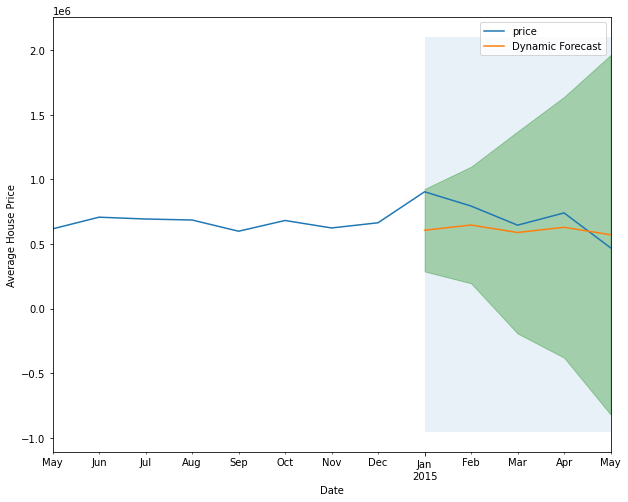

The Mean Squared Error of our forecasts is 164889.36 at zipcode 98077


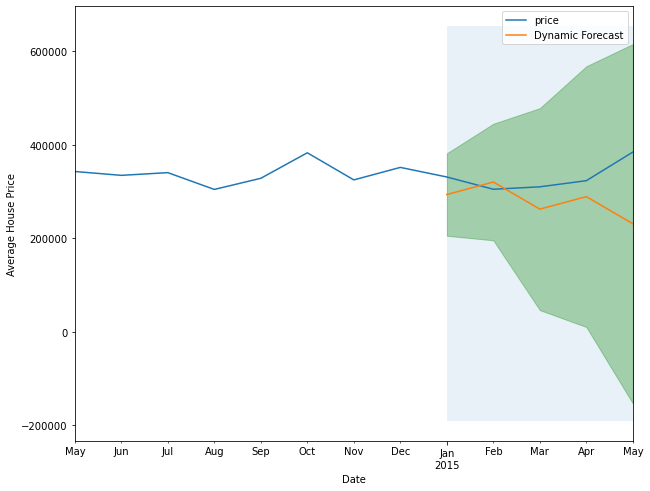

The Mean Squared Error of our forecasts is 75617.38 at zipcode 98092


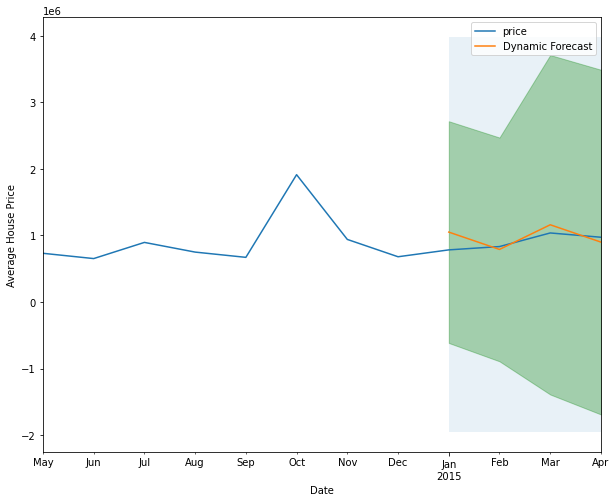

The Mean Squared Error of our forecasts is 153114.11 at zipcode 98102


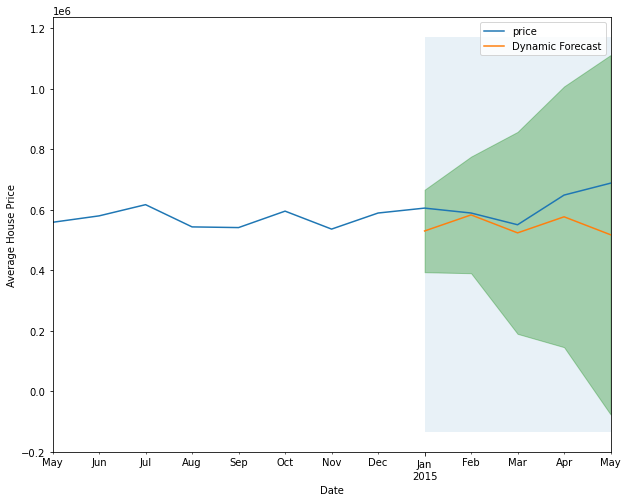

The Mean Squared Error of our forecasts is 90308.79 at zipcode 98103


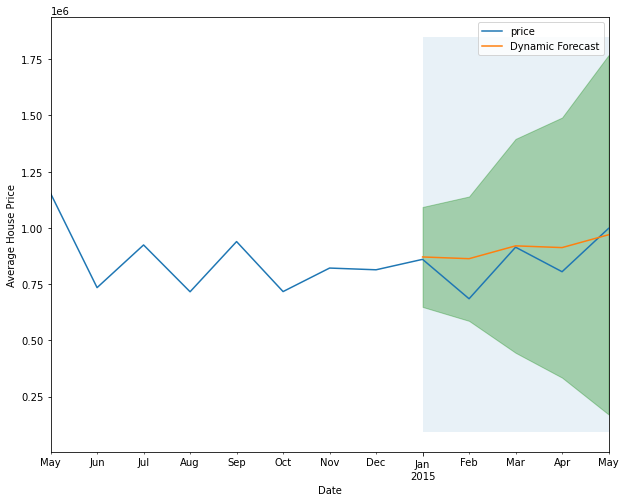

The Mean Squared Error of our forecasts is 94054.13 at zipcode 98105


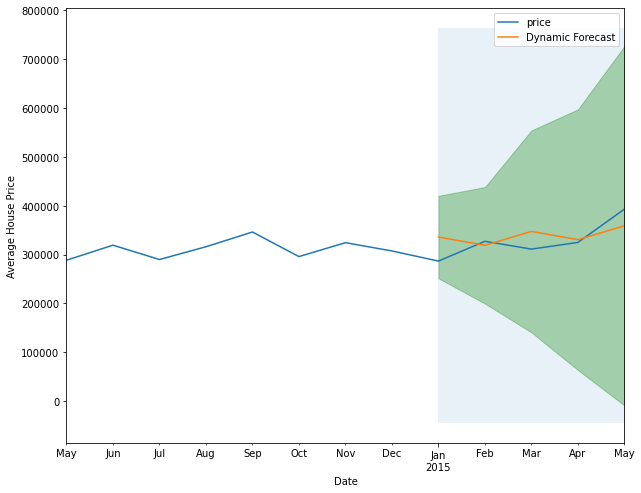

The Mean Squared Error of our forecasts is 31623.56 at zipcode 98106


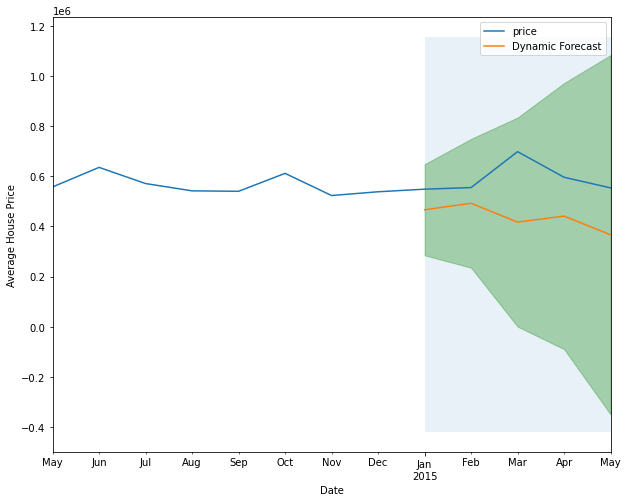

The Mean Squared Error of our forecasts is 172384.87 at zipcode 98107


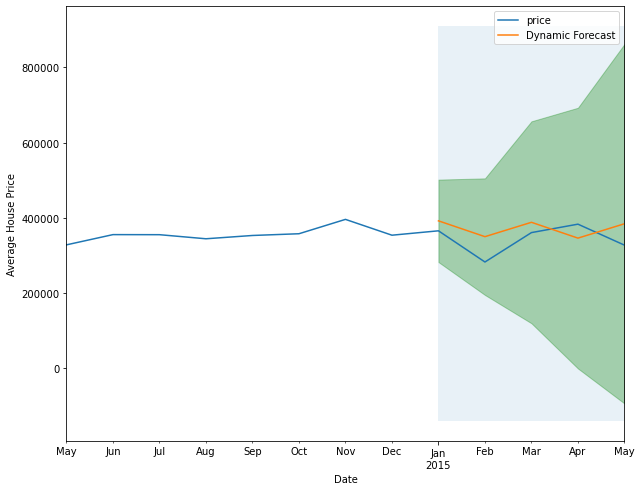

The Mean Squared Error of our forecasts is 46032.41 at zipcode 98108


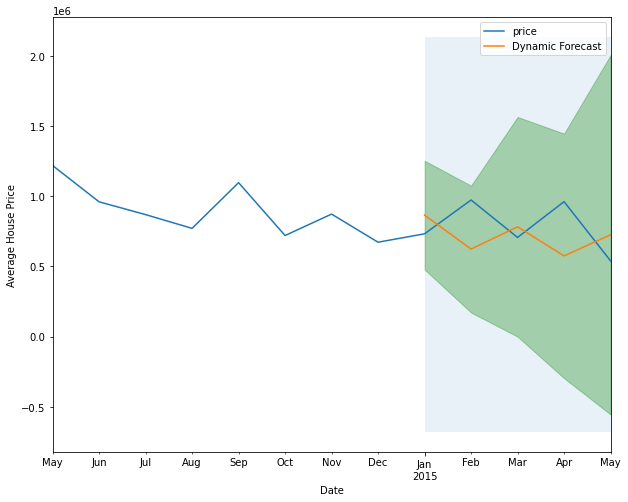

The Mean Squared Error of our forecasts is 257228.49 at zipcode 98109


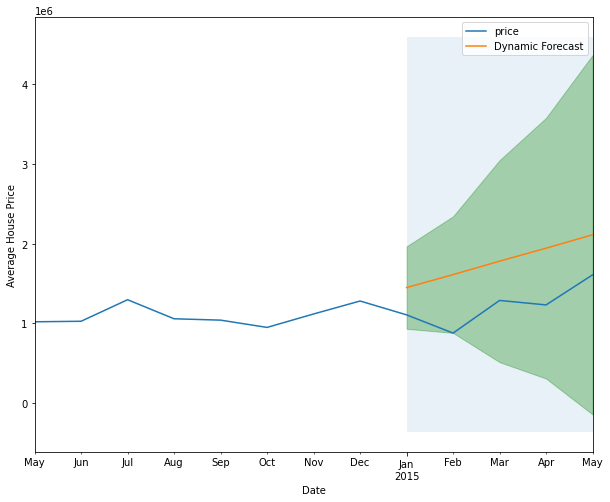

The Mean Squared Error of our forecasts is 576626.25 at zipcode 98112


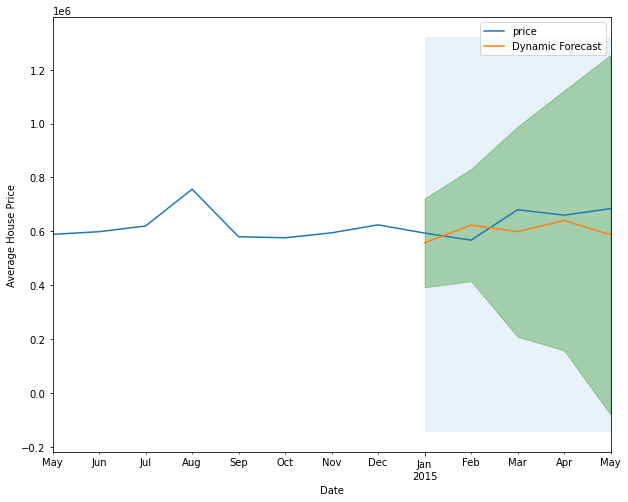

The Mean Squared Error of our forecasts is 64609.91 at zipcode 98115


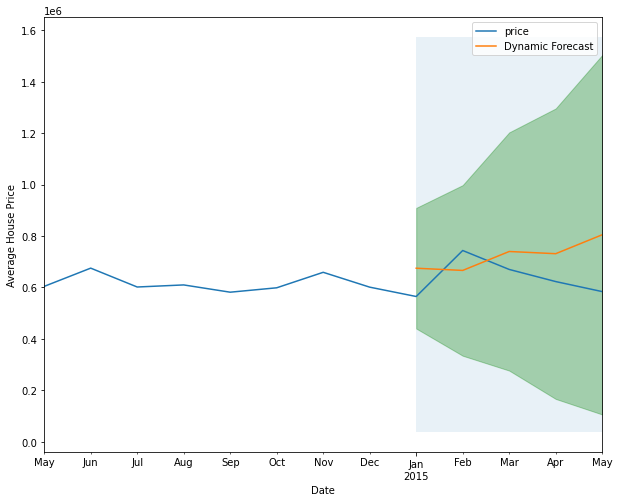

The Mean Squared Error of our forecasts is 129245.17 at zipcode 98116


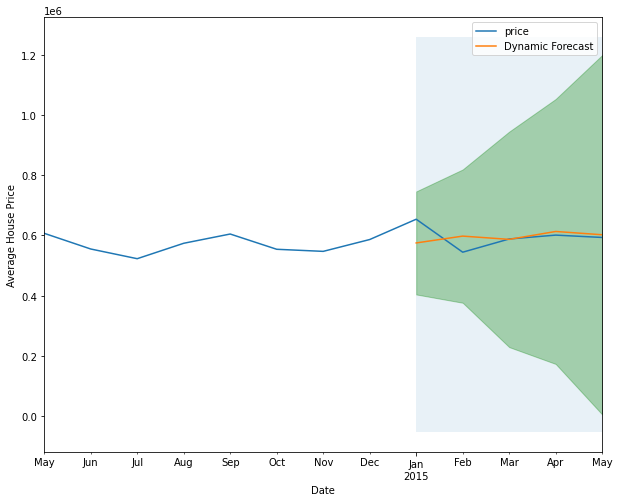

The Mean Squared Error of our forecasts is 43086.37 at zipcode 98117


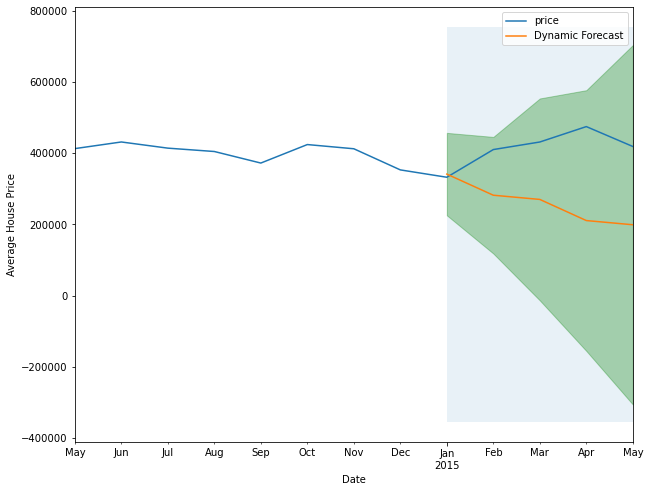

The Mean Squared Error of our forecasts is 179389.12 at zipcode 98118


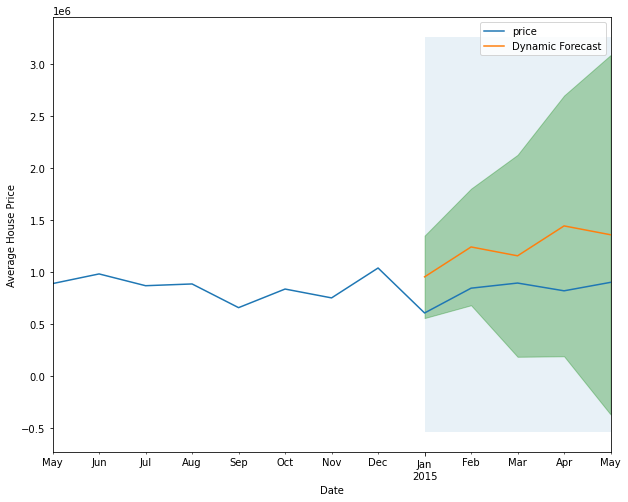

The Mean Squared Error of our forecasts is 434864.96 at zipcode 98119


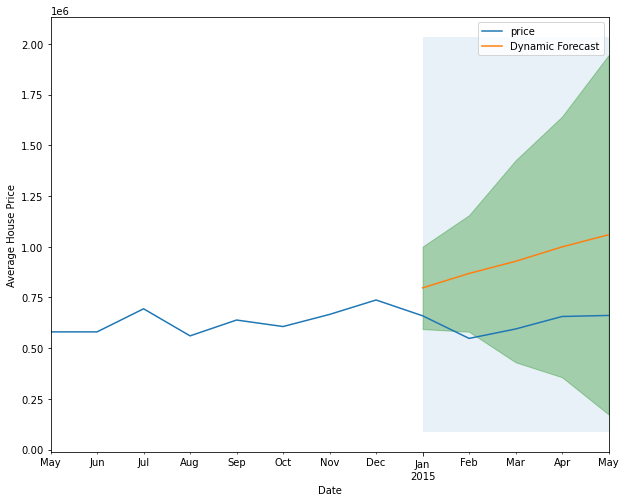

The Mean Squared Error of our forecasts is 319008.62 at zipcode 98122


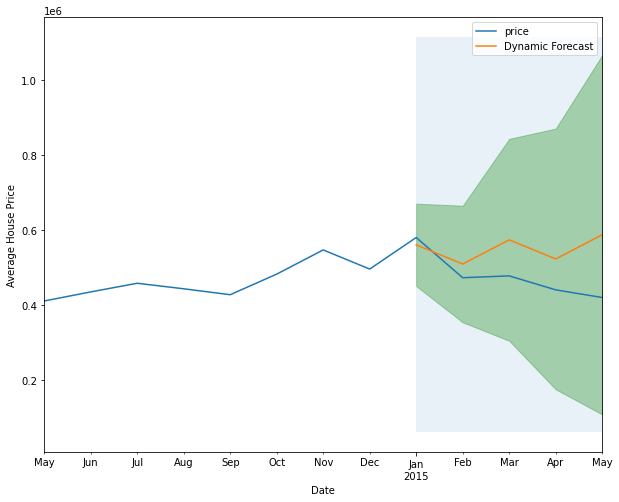

The Mean Squared Error of our forecasts is 95590.64 at zipcode 98125


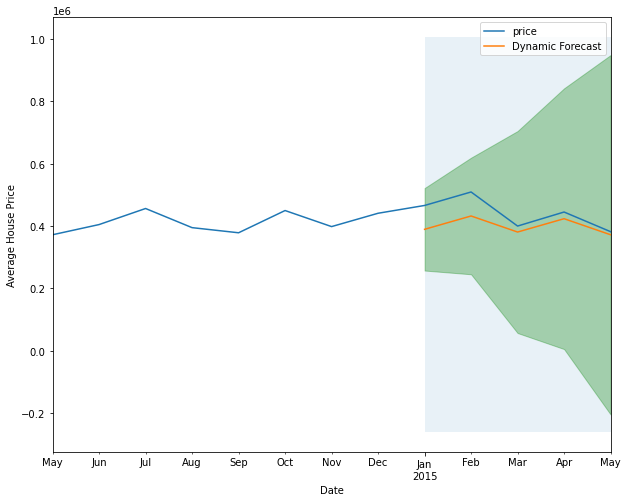

The Mean Squared Error of our forecasts is 50402.84 at zipcode 98126


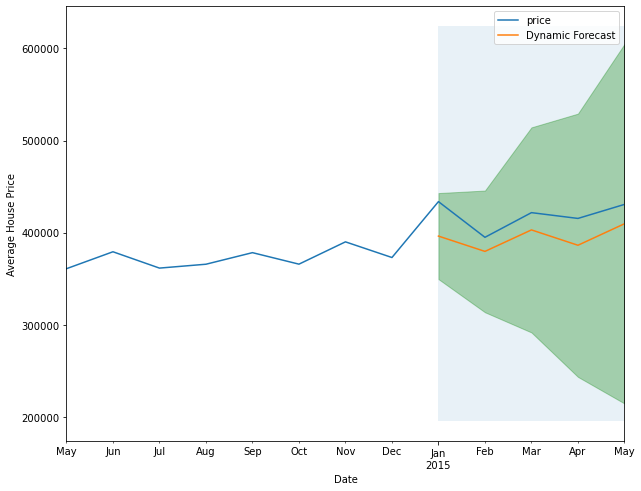

The Mean Squared Error of our forecasts is 25606.81 at zipcode 98133


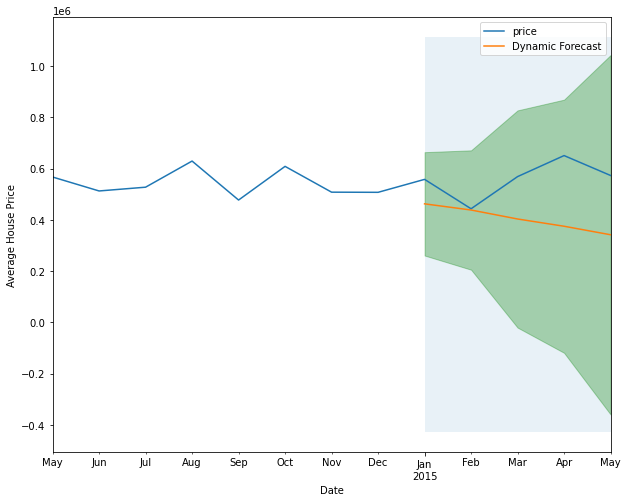

The Mean Squared Error of our forecasts is 182208.34 at zipcode 98136


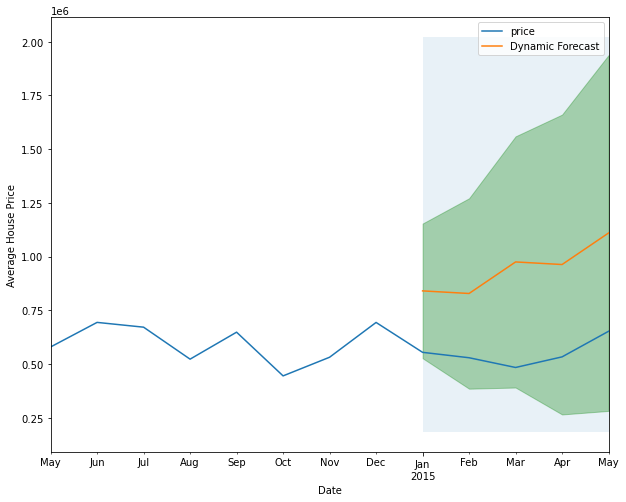

The Mean Squared Error of our forecasts is 401484.09 at zipcode 98144


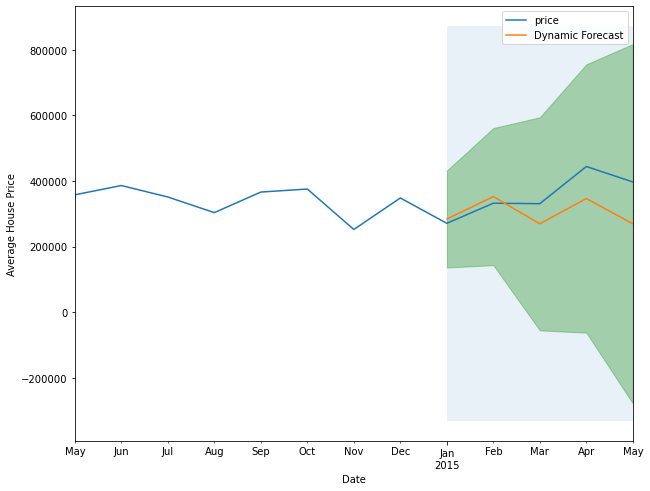

The Mean Squared Error of our forecasts is 77647.67 at zipcode 98146


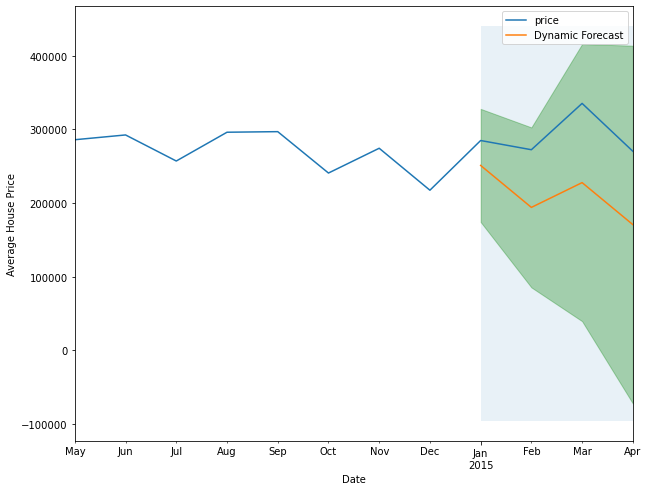

The Mean Squared Error of our forecasts is 84816.54 at zipcode 98148


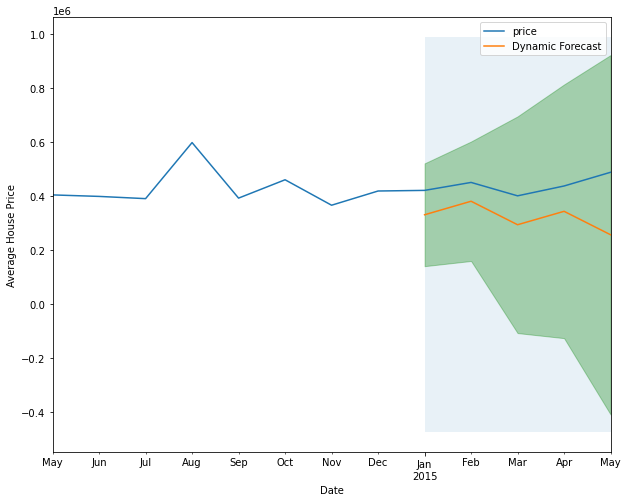

The Mean Squared Error of our forecasts is 132003.24 at zipcode 98155


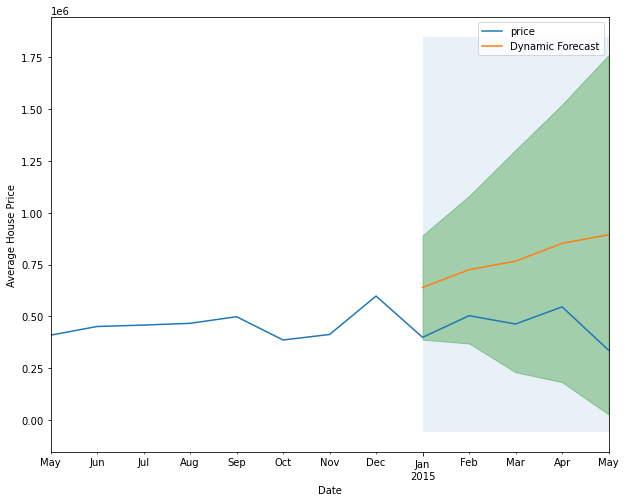

The Mean Squared Error of our forecasts is 347485.92 at zipcode 98166


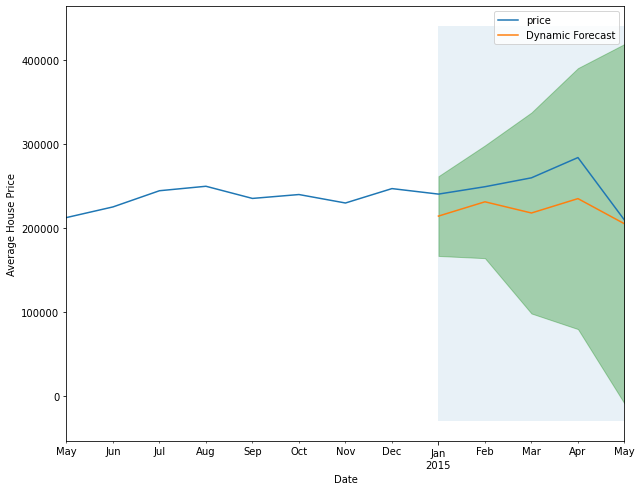

The Mean Squared Error of our forecasts is 32072.4 at zipcode 98168


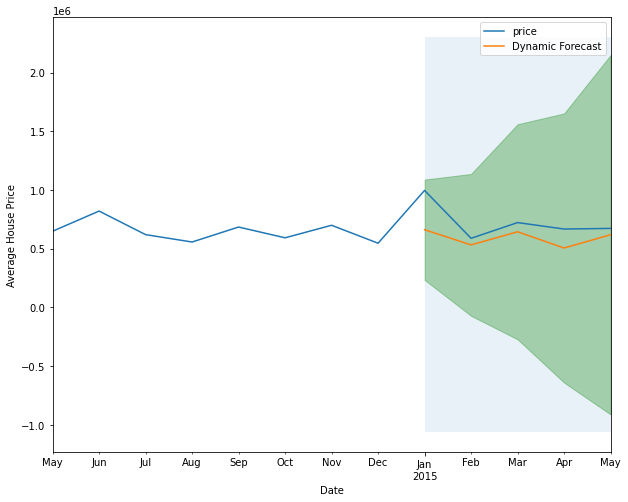

The Mean Squared Error of our forecasts is 173613.33 at zipcode 98177


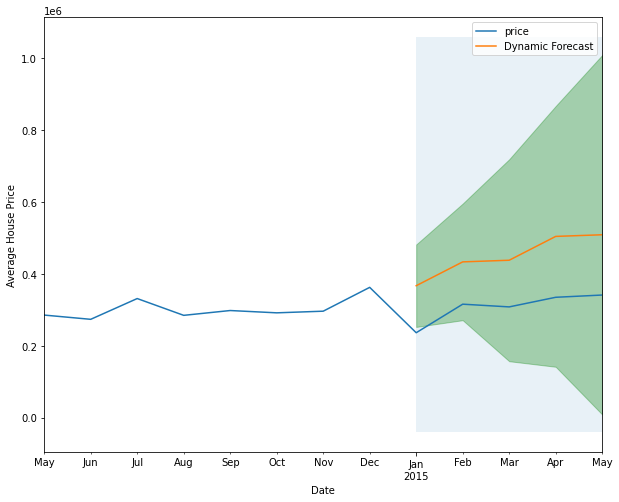

The Mean Squared Error of our forecasts is 144723.39 at zipcode 98178


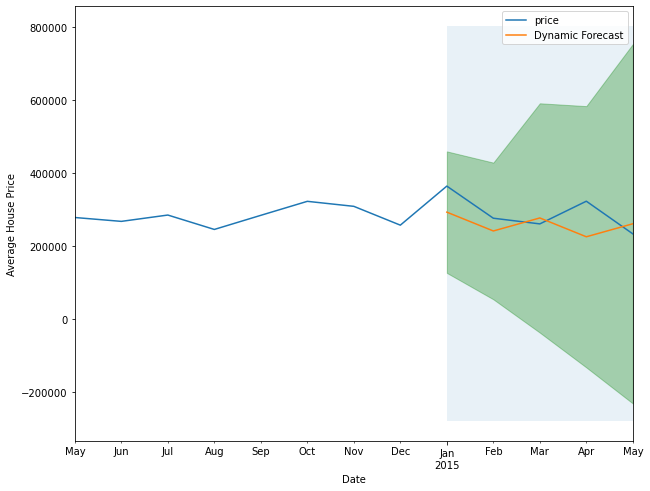

The Mean Squared Error of our forecasts is 58031.85 at zipcode 98188


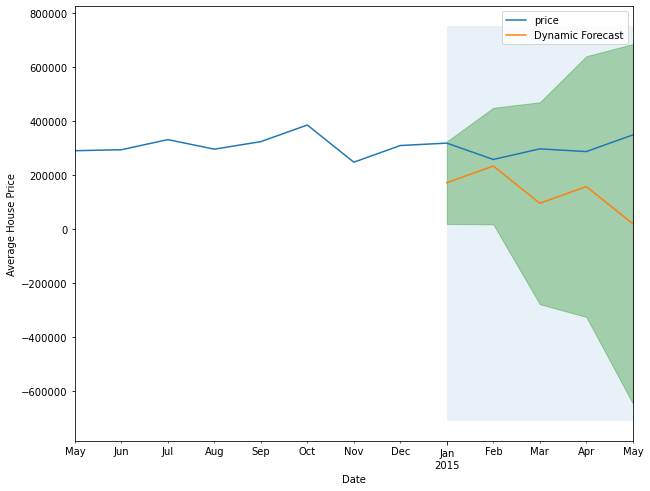

The Mean Squared Error of our forecasts is 193830.82 at zipcode 98198


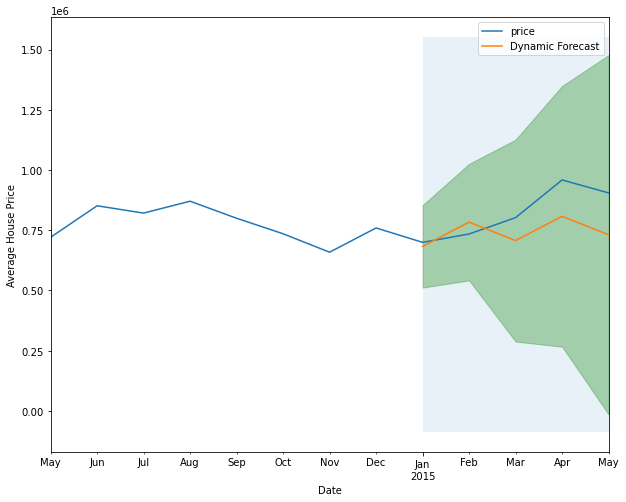

The Mean Squared Error of our forecasts is 113783.01 at zipcode 98199


In [38]:
summary_table = pd.DataFrame()
Zipcode = []
MSE_Value = []
models = []
for name, pdq, PDQS, df in zip(best_para['name'], best_para['pdq'], best_para['PDQS'], zip_dfs):
    ARIMA_MODEL = sm.tsa.SARIMAX(df,
                                 order = pdq,
                                 seasonal_order = PDQS,
                                 freq = 'MS',
                                 enforce_stationarity = True,
                                 enforce_invertibility = False)
                                
    output = ARIMA_MODEL.fit()
    models.append(output)

    pred_dynamic = output.get_prediction(start='2015-01-01', dynamic = True, full_results = True)
    pred_dynamic_conf = pred_dynamic.conf_int()
    zip_forecasted = pred_dynamic.predicted_mean
    zip_truth = df['2015-01-01':]['price']
    
    ax = df.plot(label='observed', figsize=(10, 8))
    pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

    ax.fill_between(pred_dynamic_conf.index,
                    pred_dynamic_conf.iloc[:, 0],
                    pred_dynamic_conf.iloc[:, 1], color='g', alpha=.3)

    ax.fill_betweenx(ax.get_ylim(), '2015-01-01', zip_forecasted.index[-1], alpha=.1, zorder=-1)

    ax.set_xlabel('Date')
    ax.set_ylabel('Average House Price')

    plt.legend()
    plt.show()

    sqrt_mse = np.sqrt(((zip_forecasted - zip_truth)**2).mean())
    print('The Mean Squared Error of our forecasts is {} at zipcode {}'.format(round(sqrt_mse, 2),name)) 
    
    Zipcode.append(name)
    MSE_Value.append(sqrt_mse)
    
summary_table['Zipcode'] = Zipcode
summary_table['Sqrt_MSE'] = MSE_Value

In [39]:
summary_table.sort_values(by=['Sqrt_MSE'])

Zipcode      Sqrt_MSE
57    98133  25606.806575
1     98002  28483.025688
30    98055  31275.772442
44    98106  31623.563866
64    98168  32072.397822
13    98023  32838.793111
32    98058  34472.371250
23    98038  35636.171752
18    98030  37886.861377
0     98001  39311.382123
9     98011  40044.039548
51    98117  43086.365917
46    98108  46032.410626
56    98126  50402.843523
11    98019  54719.699476
67    98188  58031.853944
49    98115  64609.911753
20    98032  65327.011977
22    98034  65486.812617
36    98072  73390.932856
38    98075  74055.253241
16    98028  74122.693735
40    98092  75617.379131
60    98146  77647.672902
61    98148  84816.542660
42    98103  90308.790312
43    98105  94054.130028
55    98125  95590.644620
17    98029  96843.077045
34    98065 100597.278840
19    98031 104948.810108
10    98014 105637.824362
12    98022 107700.366081
6     98007 108163.244300
69    98199 113783.008315
31    98056 117989.054917
15    98027 119295.236663
2     98003 123480.528531
29    98053 123574.763220
50    98116 129245.173728
62    98155 132003.237837
33    98059 133026.846708
66    98178 144723.385909
27    98045 145671.077049
41    98102 153114.110006
4     98005 154574.775630
39    98077 164889.362486
21    98033 166226.948244
45    98107 172384.872073
65    98177 173613.333454
52    98118 179389.118900
58    98136 182208.344765
3     98004 186639.536191
68    98198 193830.816737
28    98052 214174.367653
26    98042 214361.303086
25    98040 216766.541138
8     98010 249252.691166
47    98109 257228.489586
35    98070 270160.150675
7     98008 299907.116105
54    98122 319008.617041
5     98006 337361.180562
63    98166 347485.917537
59    98144 401484.085904
53    98119 434864.960430
48    98112 576626.246876
24    98039 676716.815900
37    98074 689842.138058
14    98024 751375.489706

In [40]:
summary_table.sort_values(by=['Sqrt_MSE'],ascending=False)

Zipcode      Sqrt_MSE
14    98024 751375.489706
37    98074 689842.138058
24    98039 676716.815900
48    98112 576626.246876
53    98119 434864.960430
59    98144 401484.085904
63    98166 347485.917537
5     98006 337361.180562
54    98122 319008.617041
7     98008 299907.116105
35    98070 270160.150675
47    98109 257228.489586
8     98010 249252.691166
25    98040 216766.541138
26    98042 214361.303086
28    98052 214174.367653
68    98198 193830.816737
3     98004 186639.536191
58    98136 182208.344765
52    98118 179389.118900
65    98177 173613.333454
45    98107 172384.872073
21    98033 166226.948244
39    98077 164889.362486
4     98005 154574.775630
41    98102 153114.110006
27    98045 145671.077049
66    98178 144723.385909
33    98059 133026.846708
62    98155 132003.237837
50    98116 129245.173728
29    98053 123574.763220
2     98003 123480.528531
15    98027 119295.236663
31    98056 117989.054917
69    98199 113783.008315
6     98007 108163.244300
12    98022 107700.366081
10    98014 105637.824362
19    98031 104948.810108
34    98065 100597.278840
17    98029  96843.077045
55    98125  95590.644620
43    98105  94054.130028
42    98103  90308.790312
61    98148  84816.542660
60    98146  77647.672902
40    98092  75617.379131
16    98028  74122.693735
38    98075  74055.253241
36    98072  73390.932856
22    98034  65486.812617
20    98032  65327.011977
49    98115  64609.911753
67    98188  58031.853944
11    98019  54719.699476
56    98126  50402.843523
46    98108  46032.410626
51    98117  43086.365917
9     98011  40044.039548
0     98001  39311.382123
18    98030  37886.861377
23    98038  35636.171752
32    98058  34472.371250
13    98023  32838.793111
64    98168  32072.397822
44    98106  31623.563866
30    98055  31275.772442
1     98002  28483.025688
57    98133  25606.806575

# Predicting next values

In [41]:
forecast_table = []
for zipcode, output, df in zip(Zipcode, models, zip_dfs):
    pred = []
    row = []
    row.append(zipcode)
    row.append(df.loc['2015-01-01']['price'])
    for i in range(1,25):
        pred = output.get_forecast(steps = i)   
        row.append(pred.predicted_mean.to_numpy()[-1])
    row.append((row[13] - row[1]) / row[1])
    row.append((row[19] - row[1]) / row[1])
    row.append((row[25] - row[1]) / row[1])
    forecast_table.append(row)

In [42]:
columns = ['Zipcode','Current Value','1 Months Value','2 Months Value','3 Months Value','4 Months Value','5 Months Value','6 Months Value','7 Months Value','8 Months Value','9 Months Value','10 Months Value','11 Months Value','12 Months Value','13 Months Value','14 Months Value','15 Months Value','16 Months Value','17 Months Value','18 Months Value','19 Months Value','20 Months Value','21 Months Value','22 Months Value','23 Months Value','24 Months Value','1 Year-ROI','1.5 Year-ROI','2 Year-ROI']

forecast_table = pd.DataFrame(data=forecast_table,columns=columns)
forecast_table

Zipcode  Current Value  1 Months Value  2 Months Value  3 Months Value  \
0     98001  291180.641026   398137.102562   417872.465621   483448.612696   
1     98002  192625.000000   256983.020833   300373.020833   284356.041667   
2     98003  340240.740741   330726.302499   349501.010101   367982.868155   
3     98004 1537166.666667  1897733.235261  1971633.530849  2117616.766110   
4     98005  838050.000000  1004303.014286   969616.100000  1107820.314286   
5     98006  896382.892857  1588302.537089  2402933.938056  2326512.030700   
6     98007  532275.250000   527781.387806   412823.666533   417784.743314   
7     98008  730727.272727   526946.046096   405676.213608   528948.545740   
8     98010  414583.333333   521126.779484   521978.319175   575757.151556   
9     98011  525375.000000   537027.324567   532563.847532   559877.585983   
10    98014  479833.333333   451269.545681   524674.089961   488443.635642   
11    98019  400690.000000   502723.412698   563233.333333   580257.936508   
12    98022  273961.111111   437880.465381   469015.933501   515132.278163   
13    98023  307693.229167   305285.166082   350067.180841   335805.288908   
14    98024  674378.571429   794266.431653   560390.407284   818321.838937   
15    98027  841565.909091   632355.351852   531312.379630   611055.231481   
16    98028  494638.785714   438908.637038   454132.491879   424376.034492   
17    98029  603857.812500   616022.002315   611320.104167   613512.523148   
18    98030  313167.500000   268000.520833   215223.020833   224623.541667   
19    98031  287850.000000   328933.911084   334461.278744   340051.856495   
20    98032  290285.714286   249390.277778   298777.777778   265043.055556   
21    98033  814060.714286   550247.742647   515898.988205   417303.254661   
22    98034  475036.296296   580913.828310   660287.213513   639184.375156   
23    98038  321292.288889   393256.478949   432583.226508   416788.529531   
24    98039 1615000.000000  1695414.102881  1612514.263670  1773440.356375   
25    98040 1089691.666667  1417301.472049  1582261.292646  1613612.660548   
26    98042  291447.395833       -0.010182   290817.125888       -0.003411   
27    98045  667574.550000   569580.541011   588689.622826   581334.653474   
28    98052  632967.179487   707957.492593   798749.259259   772018.001852   
29    98053  565709.500000   535426.050000   301768.550000   352804.600000   
30    98055  287785.714286   373268.553634   371633.723810   417565.177444   
31    98056  406387.000000   410235.987981   308011.031789   362687.750957   
32    98058  353550.119048   427669.509019   463131.198413   491842.374098   
33    98059  390556.111111   535295.847346   484472.888471   543499.331055   
34    98065  576411.363636   523270.509259   501325.055556   488770.564815   
35    98070  535333.333333   433254.583333   465863.333333   402977.916667   
36    98072  511477.958333   643776.406014   690367.583951   687765.989965   
37    98074  653703.400000        0.000000        0.000000        0.000000   
38    98075  794742.424242   768671.074052   777610.357355   746359.716198   
39    98077  903700.000000   564942.992424   294690.909091   389633.901515   
40    98092  331051.181818   397451.432810   458658.312037   471765.300403   
41    98102  782500.000000  1148389.446858  1083995.846858  1259935.293717   
42    98103  605429.545455   786104.392572   825533.204167   923665.596739   
43    98105  860045.000000   891246.048155  1083971.048155   977492.096310   
44    98106  286636.363636   406726.614453   474964.273183   488649.935255   
45    98107  548500.000000   472389.567432   465801.289129   380512.800538   
46    98108  365900.000000   350217.875000   294458.500000   316863.875000   
47    98109  733388.888889  1044242.457109   422634.468350  1092835.763330   
48    98112 1105248.738095  1551874.104167  1929812.500000  1873561.604167   
49    98115  593482.142857   720972.093254   734309.014470   745632.839879   
50    98116  564842.592593

In [43]:
for m,z in zip(models,Zipcode):
    m.save(str(z)+'.pkl')